<a href="https://colab.research.google.com/github/GuidoLorenzetti/TP2-AA2-Lorenzetti_Farias_Garcia/blob/main/Ejercicio%201/EJ1_TP2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabajo Practico Final - Aprendizaje Automático II



## Integrantes:




*   Lorenzetti, Guido
*   Farias, Augusto
*   Garica, Timoteo

## Problema 1 - Audio MNIST

El objetivo de este ejercicio es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Para el mismo vamos a utilizar dos tipos de arquitecturas de Redes Neuronales:
**Convolucionales y Recurrentes.**



## Setup

Importar e instalar librerías

In [1]:
!pip install keras
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=926f5a0c996f2e73ea76e8cf83d920297354c9ad9a5a072a9f02a17d4ebb25c2
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from keras.preprocessing import image
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Descargar dataset

In [4]:
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip

!unzip master.zip

--2024-07-22 20:58:26--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master [following]
--2024-07-22 20:58:26--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     <=>            ]  15.66M  17.7MB/s    in 0.9s    

2024-07-22 20:58:28 (17.7 MB/s) - ‘master.zip’ saved [16422817]

Archive:  master.zip
26eb9aaf76e81b692f806f9140c2d2777410d7a1
   creating: free-spok

## Organizar archivos por etiquetas

In [5]:
import os
import shutil

# Ruta de la carpeta con los archivos de audio
input_folder = '/content/free-spoken-digit-dataset-master/recordings'

# Crear carpetas para las etiquetas si no existen
for i in range(10):
    label_folder = os.path.join(input_folder, str(i))
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)

# Mover archivos a las carpetas correspondientes
for filename in os.listdir(input_folder):
    if filename.endswith('.wav'):
        # Obtener la etiqueta del archivo
        label = filename.split('_')[0]
        # Ruta del archivo original
        src_path = os.path.join(input_folder, filename)
        # Ruta de destino
        dest_path = os.path.join(input_folder, label, filename)
        # Mover el archivo
        shutil.move(src_path, dest_path)

print("Archivos organizados por etiquetas.")



Archivos organizados por etiquetas.



## Split data

In [6]:
import pathlib
data_dir = pathlib.Path("free-spoken-digit-dataset-master/recordings/")

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

## Chequear balance del dataset


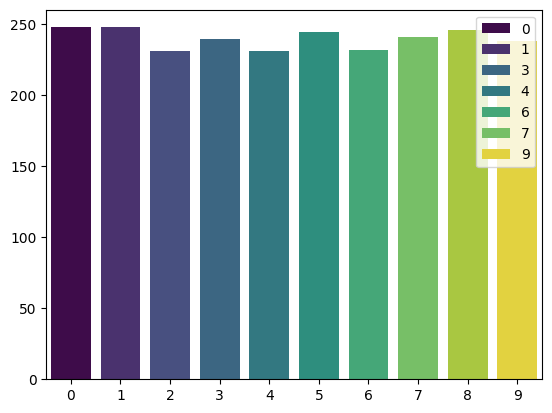

In [9]:
label_counts = {}
for _, label in train_ds:
  label = label.numpy()
  for l in label:
    if l not in label_counts:
      label_counts[l] = 0
    label_counts[l] += 1

keys = list(label_counts.keys())
vals = list(label_counts.values())

sns.barplot(x=keys, y=vals, hue = keys ,palette='viridis')
plt.show()

## Procesamiento archivos de audio

In [10]:
def squeeze(audio, labels):
  """Descarto eje extra de canales"""
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [11]:
for example_audio, example_labels in train_ds.take(1):
  print("(Batch, samples): ",example_audio.shape)
  print(example_labels.shape)

(Batch, samples):  (64, 8000)
(64,)


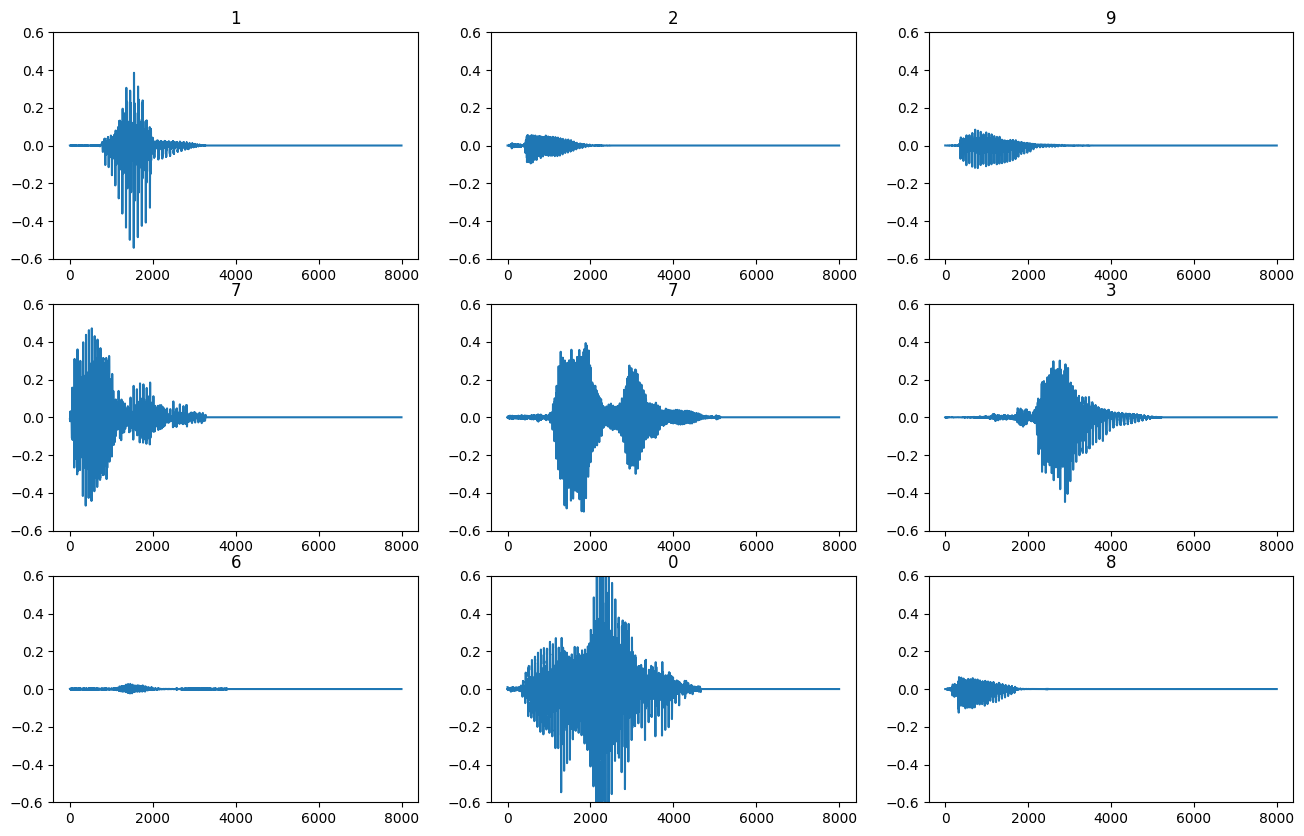

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-0.6, 0.6])

In [13]:
def get_spectrogram(waveform):
  """Convertir ondas a spectrograms usando transformada de Fourier"""

  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  # Obtengo la magnitud
  spectrogram = tf.abs(spectrogram)

  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape: (tiempo, frecuencia, canal de amplitud)', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 1
Waveform shape: (8000,)
Spectrogram shape: (tiempo, frecuencia, canal de amplitud) (61, 129, 1)
Audio playback


Label: 2
Waveform shape: (8000,)
Spectrogram shape: (tiempo, frecuencia, canal de amplitud) (61, 129, 1)
Audio playback


Label: 9
Waveform shape: (8000,)
Spectrogram shape: (tiempo, frecuencia, canal de amplitud) (61, 129, 1)
Audio playback


Label: 7
Waveform shape: (8000,)
Spectrogram shape: (tiempo, frecuencia, canal de amplitud) (61, 129, 1)
Audio playback


Label: 7
Waveform shape: (8000,)
Spectrogram shape: (tiempo, frecuencia, canal de amplitud) (61, 129, 1)
Audio playback


Label: 3
Waveform shape: (8000,)
Spectrogram shape: (tiempo, frecuencia, canal de amplitud) (61, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  """Mostrar espectograma"""
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

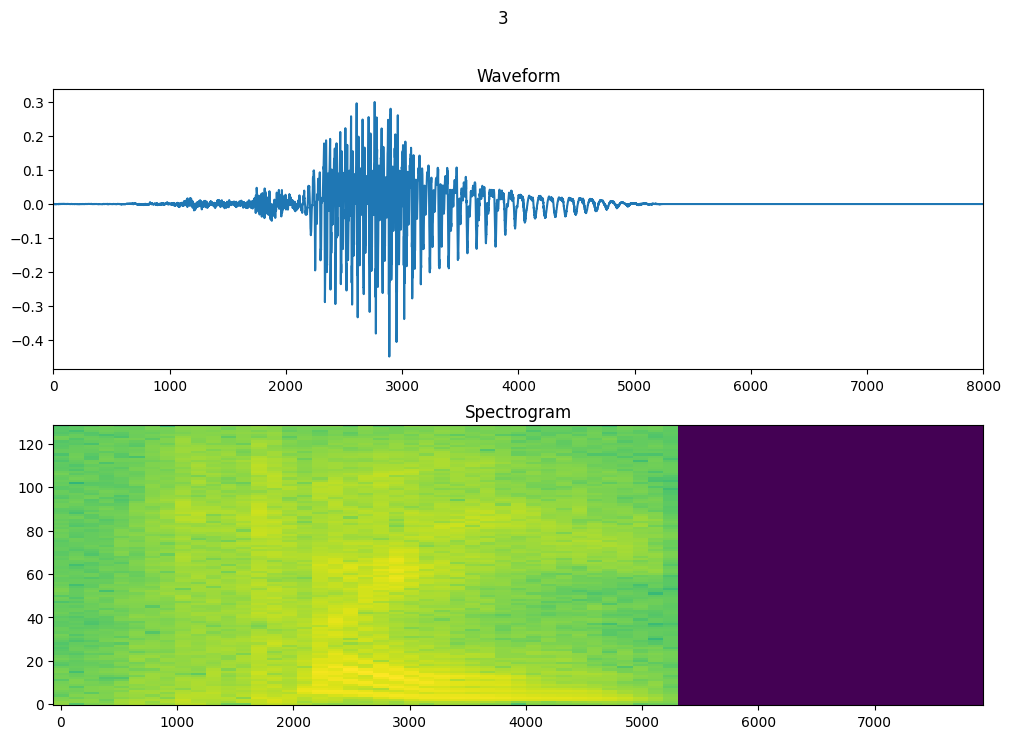

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [17]:
def make_spec_ds(ds):
  """Map clips with spectrogram"""
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

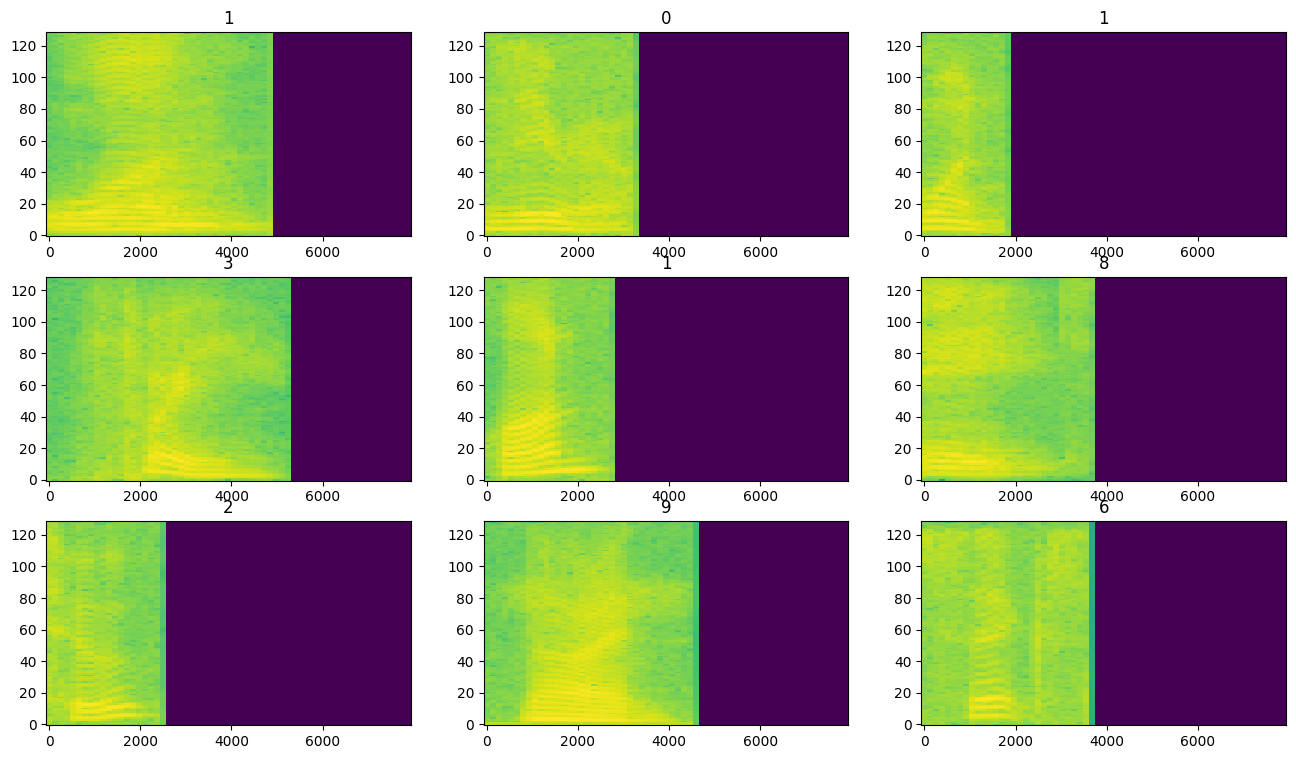

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Entrenar CNN

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [28]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

"""
model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=data_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax'))
"""


model.summary()

Input shape: (61, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)        

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
38/38 [==============================] - 2s 17ms/step - loss: 1.8228 - accuracy: 0.3554 - val_loss: 1.2521 - val_accuracy: 0.6483
Epoch 2/50
38/38 [==============================] - 0s 12ms/step - loss: 1.2249 - accuracy: 0.5950 - val_loss: 0.8769 - val_accuracy: 0.7383
Epoch 3/50
38/38 [==============================] - 0s 11ms/step - loss: 0.8912 - accuracy: 0.6929 - val_loss: 0.6298 - val_accuracy: 0.8250
Epoch 4/50
38/38 [==============================] - 0s 13ms/step - loss: 0.7198 - accuracy: 0.7725 - val_loss: 0.4674 - val_accuracy: 0.8850
Epoch 5/50
38/38 [==============================] - 0s 12ms/step - loss: 0.5730 - accuracy: 0.8246 - val_loss: 0.3942 - val_accuracy: 0.8967
Epoch 6/50
38/38 [==============================] - 1s 17ms/step - loss: 0.4654 - accuracy: 0.8579 - val_loss: 0.2909 - val_accuracy: 0.9350
Epoch 7/50
38/38 [==============================] - 1s 13ms/step - loss: 0.3934 - accuracy: 0.8779 - val_loss: 0.2806 - val_accuracy: 0.9300
Epoch 8/50
38

## Metricas del modelo

Text(0, 0.5, 'Accuracy [%]')

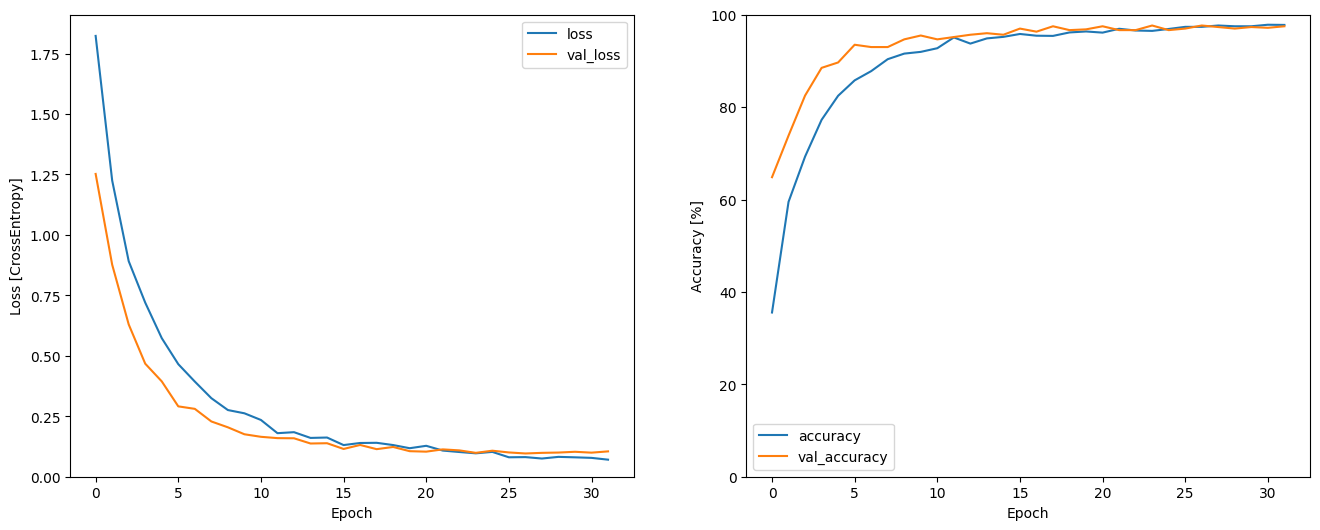

In [31]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [32]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

10/10 [==============================] - 0s 3ms/step


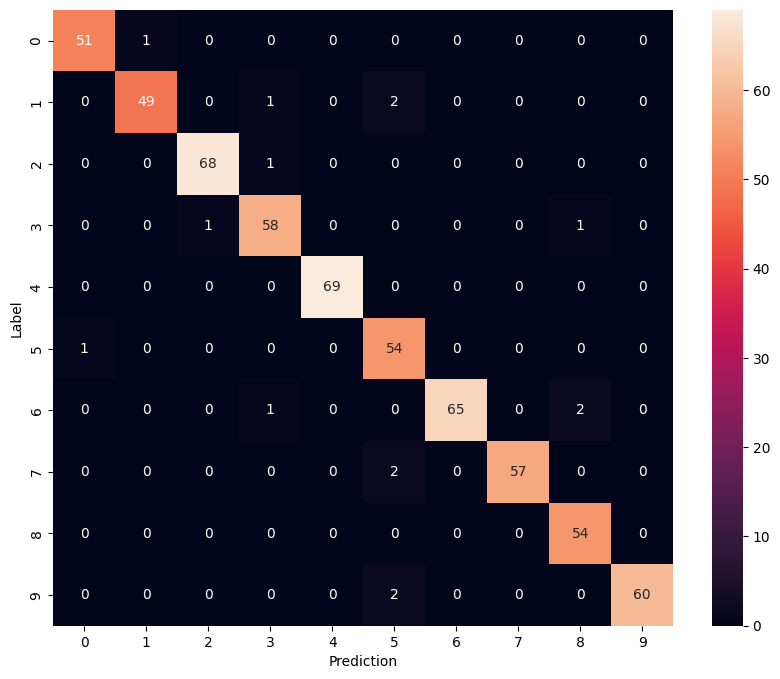

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [35]:
##Add classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.94      0.96        52
           2       0.99      0.99      0.99        69
           3       0.95      0.97      0.96        60
           4       1.00      1.00      1.00        69
           5       0.90      0.98      0.94        55
           6       1.00      0.96      0.98        68
           7       1.00      0.97      0.98        59
           8       0.95      1.00      0.97        54
           9       1.00      0.97      0.98        62

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.98      0.97      0.98       600



## Entrenar RNN

In [37]:
def wav_to_spectrogram(audio_path, spectrogram_path, spectrogram_dimensions=(128, 128), noverlap=128, cmap='viridis'):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.56, 2.56))
    plt.axis('off')
    plt.margins(0, 0)
    plt.imshow(S_db, aspect='auto', cmap=cmap)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.gcf().set_size_inches(spectrogram_dimensions[0] / 100.0, spectrogram_dimensions[1] / 100.0)
    plt.gcf().set_dpi(100)
    plt.savefig(spectrogram_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def dir_to_spectrogram(root_audio_dir, root_spectrogram_dir, spectrogram_dimensions=(128, 128), noverlap=128, cmap='viridis'):
    if not os.path.exists(root_spectrogram_dir):
        os.makedirs(root_spectrogram_dir)

    for folder in os.listdir(root_audio_dir):
        audio_dir = os.path.join(root_audio_dir, folder)
        if not os.path.isdir(audio_dir):
            continue

        spectrogram_dir = os.path.join(root_spectrogram_dir, folder)
        if not os.path.exists(spectrogram_dir):
            os.makedirs(spectrogram_dir)

        file_names = [f for f in os.listdir(audio_dir) if os.path.isfile(os.path.join(audio_dir, f)) and f.endswith('.wav')]
        for file_name in file_names:
            print(f'Processing {file_name} in {folder}')
            audio_path = os.path.join(audio_dir, file_name)
            spectrogram_path = os.path.join(spectrogram_dir, file_name.replace('.wav', '.png'))
            wav_to_spectrogram(audio_path, spectrogram_path, spectrogram_dimensions=spectrogram_dimensions, noverlap=noverlap, cmap=cmap)

def load_spectrograms(root_dir, img_size=(128, 128)):
    images = []
    labels = []

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                # Cargar imagen y convertir a array
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=img_size, color_mode='grayscale')
                img_array = img_to_array(img)

                # Normalizar el array de la imagen
                img_array /= 255.0

                # Añadir a la lista de imágenes
                images.append(img_array)
                labels.append(int(folder))  # Etiqueta basada en el nombre de la carpeta

    images = np.array(images)
    labels = np.array(labels)

    # Reformar las imágenes para que tengan la forma (n_samples, timesteps, features)
    images = images.reshape((images.shape[0], img_size[0], img_size[1]))

    return images, labels

In [38]:
def build_recurrent_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(10, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [40]:
!pip install librosa

In [43]:
import librosa

In [44]:
root_audio_dir = "./free-spoken-digit-dataset-master/recordings/"
spectrogram_root_dir = "./spectrograms/"

# Crear espectrogramas
dir_to_spectrogram(root_audio_dir, spectrogram_root_dir)

Processing 0_theo_40.wav in 0
Processing 0_nicolas_47.wav in 0
Processing 0_theo_5.wav in 0
Processing 0_george_23.wav in 0
Processing 0_theo_20.wav in 0
Processing 0_lucas_1.wav in 0
Processing 0_yweweler_15.wav in 0
Processing 0_theo_6.wav in 0
Processing 0_george_41.wav in 0
Processing 0_george_33.wav in 0
Processing 0_jackson_28.wav in 0
Processing 0_nicolas_22.wav in 0
Processing 0_george_24.wav in 0
Processing 0_theo_7.wav in 0
Processing 0_nicolas_35.wav in 0
Processing 0_theo_32.wav in 0
Processing 0_lucas_46.wav in 0
Processing 0_lucas_13.wav in 0
Processing 0_nicolas_40.wav in 0
Processing 0_jackson_36.wav in 0
Processing 0_lucas_0.wav in 0
Processing 0_jackson_45.wav in 0
Processing 0_nicolas_21.wav in 0
Processing 0_george_44.wav in 0
Processing 0_yweweler_18.wav in 0
Processing 0_george_42.wav in 0
Processing 0_yweweler_21.wav in 0
Processing 0_lucas_47.wav in 0
Processing 0_nicolas_4.wav in 0
Processing 0_theo_31.wav in 0
Processing 0_yweweler_28.wav in 0
Processing 0_luc

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(


Processing 1_nicolas_29.wav in 1
Processing 1_nicolas_33.wav in 1
Processing 1_george_27.wav in 1
Processing 1_lucas_1.wav in 1
Processing 1_jackson_43.wav in 1
Processing 1_nicolas_7.wav in 1
Processing 1_yweweler_18.wav in 1
Processing 1_nicolas_16.wav in 1
Processing 1_lucas_24.wav in 1
Processing 1_theo_5.wav in 1
Processing 1_george_32.wav in 1
Processing 1_jackson_2.wav in 1
Processing 1_lucas_44.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1737
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(


Processing 1_theo_40.wav in 1
Processing 1_jackson_26.wav in 1
Processing 1_yweweler_14.wav in 1
Processing 1_lucas_5.wav in 1
Processing 1_jackson_22.wav in 1
Processing 1_lucas_12.wav in 1
Processing 1_george_11.wav in 1
Processing 1_george_30.wav in 1
Processing 1_lucas_4.wav in 1
Processing 1_lucas_28.wav in 1
Processing 1_lucas_8.wav in 1
Processing 1_yweweler_11.wav in 1
Processing 1_theo_6.wav in 1
Processing 1_lucas_3.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(


Processing 1_george_20.wav in 1
Processing 1_yweweler_38.wav in 1
Processing 1_yweweler_4.wav in 1
Processing 1_theo_30.wav in 1
Processing 1_jackson_46.wav in 1
Processing 1_george_29.wav in 1
Processing 1_george_44.wav in 1
Processing 1_jackson_20.wav in 1
Processing 1_yweweler_0.wav in 1
Processing 1_nicolas_34.wav in 1
Processing 1_jackson_41.wav in 1
Processing 1_theo_15.wav in 1
Processing 1_jackson_39.wav in 1
Processing 1_yweweler_31.wav in 1
Processing 1_george_1.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1813
  warnings.warn(


Processing 1_yweweler_2.wav in 1
Processing 1_george_12.wav in 1
Processing 1_nicolas_43.wav in 1
Processing 1_jackson_42.wav in 1
Processing 1_lucas_2.wav in 1
Processing 1_theo_23.wav in 1
Processing 1_lucas_20.wav in 1
Processing 1_yweweler_19.wav in 1
Processing 1_theo_47.wav in 1
Processing 1_george_49.wav in 1
Processing 1_jackson_24.wav in 1
Processing 1_jackson_4.wav in 1
Processing 1_jackson_19.wav in 1
Processing 1_theo_14.wav in 1
Processing 1_jackson_5.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(


Processing 1_george_19.wav in 1
Processing 1_yweweler_27.wav in 1
Processing 1_yweweler_44.wav in 1
Processing 1_nicolas_35.wav in 1
Processing 1_theo_26.wav in 1
Processing 1_george_9.wav in 1
Processing 1_lucas_15.wav in 1
Processing 1_jackson_11.wav in 1
Processing 1_jackson_8.wav in 1
Processing 1_george_45.wav in 1
Processing 1_jackson_29.wav in 1
Processing 1_yweweler_16.wav in 1
Processing 1_yweweler_21.wav in 1
Processing 1_jackson_10.wav in 1
Processing 1_yweweler_46.wav in 1
Processing 1_nicolas_18.wav in 1
Processing 1_yweweler_30.wav in 1
Processing 1_lucas_22.wav in 1
Processing 1_george_31.wav in 1
Processing 1_lucas_41.wav in 1
Processing 1_yweweler_6.wav in 1
Processing 1_yweweler_9.wav in 1
Processing 1_yweweler_23.wav in 1
Processing 1_lucas_37.wav in 1
Processing 1_george_40.wav in 1
Processing 1_george_38.wav in 1
Processing 1_lucas_10.wav in 1
Processing 1_jackson_7.wav in 1
Processing 1_jackson_32.wav in 1
Processing 1_jackson_15.wav in 1
Processing 1_nicolas_4.wa

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1565
  warnings.warn(


Processing 1_jackson_6.wav in 1
Processing 1_theo_42.wav in 1
Processing 1_yweweler_13.wav in 1
Processing 1_theo_35.wav in 1
Processing 1_lucas_46.wav in 1
Processing 1_theo_32.wav in 1
Processing 1_jackson_35.wav in 1
Processing 1_jackson_34.wav in 1
Processing 1_lucas_47.wav in 1
Processing 1_nicolas_5.wav in 1
Processing 1_nicolas_27.wav in 1
Processing 1_yweweler_12.wav in 1
Processing 1_nicolas_44.wav in 1
Processing 1_theo_41.wav in 1
Processing 1_george_47.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1692
  warnings.warn(


Processing 1_jackson_13.wav in 1
Processing 1_nicolas_28.wav in 1
Processing 1_george_46.wav in 1
Processing 1_yweweler_48.wav in 1
Processing 1_yweweler_5.wav in 1
Processing 1_george_26.wav in 1
Processing 1_yweweler_20.wav in 1
Processing 1_theo_25.wav in 1
Processing 1_lucas_38.wav in 1
Processing 1_lucas_39.wav in 1
Processing 1_yweweler_45.wav in 1
Processing 1_jackson_23.wav in 1
Processing 1_nicolas_30.wav in 1
Processing 1_lucas_17.wav in 1
Processing 1_yweweler_37.wav in 1
Processing 1_jackson_18.wav in 1
Processing 1_lucas_26.wav in 1
Processing 1_lucas_0.wav in 1
Processing 1_george_42.wav in 1
Processing 1_yweweler_1.wav in 1
Processing 1_nicolas_12.wav in 1
Processing 1_yweweler_7.wav in 1
Processing 1_yweweler_40.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1785
  warnings.warn(


Processing 1_nicolas_49.wav in 1
Processing 1_yweweler_32.wav in 1
Processing 1_george_34.wav in 1
Processing 1_theo_29.wav in 1
Processing 1_nicolas_23.wav in 1
Processing 1_lucas_36.wav in 1
Processing 1_jackson_14.wav in 1
Processing 1_nicolas_48.wav in 1
Processing 1_nicolas_19.wav in 1
Processing 1_lucas_9.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(


Processing 1_george_18.wav in 1
Processing 1_george_15.wav in 1
Processing 1_jackson_9.wav in 1
Processing 1_nicolas_8.wav in 1
Processing 1_lucas_43.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(


Processing 1_jackson_44.wav in 1
Processing 1_theo_31.wav in 1
Processing 1_lucas_14.wav in 1
Processing 1_jackson_48.wav in 1
Processing 1_yweweler_34.wav in 1
Processing 1_lucas_6.wav in 1
Processing 1_george_16.wav in 1
Processing 1_george_43.wav in 1
Processing 1_yweweler_26.wav in 1
Processing 1_lucas_16.wav in 1
Processing 1_george_22.wav in 1
Processing 1_george_3.wav in 1
Processing 1_yweweler_24.wav in 1
Processing 1_theo_18.wav in 1
Processing 1_jackson_30.wav in 1
Processing 1_nicolas_10.wav in 1
Processing 1_nicolas_17.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1788
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(


Processing 1_nicolas_3.wav in 1
Processing 1_yweweler_49.wav in 1
Processing 1_theo_19.wav in 1
Processing 1_nicolas_36.wav in 1
Processing 1_george_13.wav in 1
Processing 1_lucas_25.wav in 1
Processing 1_jackson_1.wav in 1
Processing 1_jackson_21.wav in 1
Processing 1_yweweler_36.wav in 1
Processing 1_theo_48.wav in 1
Processing 1_theo_10.wav in 1
Processing 1_lucas_32.wav in 1
Processing 1_theo_4.wav in 1
Processing 1_jackson_31.wav in 1
Processing 1_george_0.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1720
  warnings.warn(


Processing 1_theo_7.wav in 1
Processing 1_nicolas_38.wav in 1
Processing 1_yweweler_28.wav in 1
Processing 1_theo_49.wav in 1
Processing 1_theo_46.wav in 1
Processing 1_lucas_31.wav in 1
Processing 1_jackson_17.wav in 1
Processing 1_jackson_16.wav in 1
Processing 1_theo_17.wav in 1
Processing 1_theo_9.wav in 1
Processing 1_nicolas_14.wav in 1
Processing 1_nicolas_24.wav in 1
Processing 1_george_7.wav in 1
Processing 1_george_8.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1890
  warnings.warn(


Processing 1_george_10.wav in 1
Processing 1_theo_13.wav in 1
Processing 1_jackson_45.wav in 1
Processing 1_lucas_35.wav in 1
Processing 1_george_36.wav in 1
Processing 1_jackson_12.wav in 1
Processing 1_nicolas_6.wav in 1
Processing 1_theo_20.wav in 1
Processing 1_nicolas_45.wav in 1
Processing 1_yweweler_41.wav in 1
Processing 1_nicolas_47.wav in 1
Processing 1_nicolas_39.wav in 1
Processing 1_nicolas_13.wav in 1
Processing 1_lucas_34.wav in 1
Processing 1_theo_43.wav in 1
Processing 1_nicolas_31.wav in 1
Processing 1_lucas_48.wav in 1
Processing 1_yweweler_15.wav in 1
Processing 1_nicolas_15.wav in 1
Processing 1_nicolas_22.wav in 1
Processing 1_nicolas_0.wav in 1
Processing 1_nicolas_41.wav in 1
Processing 1_george_21.wav in 1
Processing 1_lucas_7.wav in 1
Processing 1_nicolas_37.wav in 1
Processing 1_yweweler_35.wav in 1
Processing 1_theo_24.wav in 1
Processing 1_yweweler_17.wav in 1
Processing 1_lucas_40.wav in 1
Processing 1_lucas_13.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2016
  warnings.warn(


Processing 1_nicolas_21.wav in 1
Processing 1_jackson_0.wav in 1
Processing 1_jackson_47.wav in 1
Processing 1_yweweler_43.wav in 1
Processing 1_theo_1.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(


Processing 1_theo_37.wav in 1
Processing 1_george_35.wav in 1
Processing 1_theo_21.wav in 1
Processing 1_jackson_27.wav in 1
Processing 1_george_5.wav in 1
Processing 1_theo_22.wav in 1
Processing 1_lucas_33.wav in 1
Processing 1_jackson_33.wav in 1
Processing 1_yweweler_47.wav in 1
Processing 1_theo_34.wav in 1
Processing 1_lucas_11.wav in 1
Processing 1_lucas_18.wav in 1
Processing 1_lucas_49.wav in 1
Processing 1_george_6.wav in 1
Processing 1_george_24.wav in 1
Processing 1_jackson_40.wav in 1
Processing 1_george_33.wav in 1
Processing 1_lucas_23.wav in 1
Processing 1_theo_44.wav in 1
Processing 1_george_17.wav in 1
Processing 1_lucas_29.wav in 1
Processing 1_lucas_30.wav in 1
Processing 1_nicolas_9.wav in 1
Processing 1_yweweler_10.wav in 1
Processing 1_jackson_3.wav in 1
Processing 1_yweweler_33.wav in 1
Processing 1_george_48.wav in 1
Processing 1_jackson_25.wav in 1
Processing 1_george_41.wav in 1
Processing 1_george_25.wav in 1
Processing 1_theo_39.wav in 1
Processing 1_jackso

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(


Processing 1_yweweler_3.wav in 1
Processing 1_theo_11.wav in 1
Processing 1_nicolas_20.wav in 1
Processing 1_theo_12.wav in 1
Processing 1_yweweler_25.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1753
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1870
  warnings.warn(


Processing 1_george_4.wav in 1
Processing 1_george_28.wav in 1
Processing 1_george_14.wav in 1
Processing 1_george_39.wav in 1
Processing 1_nicolas_25.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(


Processing 1_lucas_42.wav in 1
Processing 1_theo_33.wav in 1
Processing 1_jackson_28.wav in 1
Processing 1_theo_0.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(


Processing 1_theo_36.wav in 1
Processing 1_jackson_38.wav in 1
Processing 1_theo_2.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1556
  warnings.warn(


Processing 1_nicolas_11.wav in 1
Processing 1_yweweler_42.wav in 1
Processing 1_nicolas_26.wav in 1
Processing 1_lucas_27.wav in 1
Processing 1_theo_3.wav in 1
Processing 1_nicolas_32.wav in 1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1997
  warnings.warn(


Processing 1_nicolas_46.wav in 1
Processing 1_yweweler_22.wav in 1
Processing 1_theo_27.wav in 1
Processing 2_nicolas_37.wav in 2
Processing 2_yweweler_34.wav in 2
Processing 2_george_42.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1597
  warnings.warn(


Processing 2_nicolas_10.wav in 2
Processing 2_yweweler_31.wav in 2
Processing 2_nicolas_16.wav in 2
Processing 2_george_11.wav in 2
Processing 2_george_47.wav in 2
Processing 2_george_1.wav in 2
Processing 2_george_44.wav in 2
Processing 2_theo_18.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1639
  warnings.warn(


Processing 2_george_22.wav in 2
Processing 2_theo_46.wav in 2
Processing 2_jackson_32.wav in 2
Processing 2_lucas_19.wav in 2
Processing 2_theo_37.wav in 2
Processing 2_nicolas_20.wav in 2
Processing 2_yweweler_36.wav in 2
Processing 2_nicolas_4.wav in 2
Processing 2_lucas_29.wav in 2
Processing 2_jackson_38.wav in 2
Processing 2_george_34.wav in 2
Processing 2_nicolas_34.wav in 2
Processing 2_jackson_45.wav in 2
Processing 2_george_13.wav in 2
Processing 2_lucas_5.wav in 2
Processing 2_theo_39.wav in 2
Processing 2_theo_49.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2042
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1742
  warnings.warn(


Processing 2_theo_31.wav in 2
Processing 2_nicolas_24.wav in 2
Processing 2_lucas_25.wav in 2
Processing 2_lucas_47.wav in 2
Processing 2_george_41.wav in 2
Processing 2_jackson_22.wav in 2
Processing 2_lucas_49.wav in 2
Processing 2_jackson_47.wav in 2
Processing 2_lucas_30.wav in 2
Processing 2_nicolas_26.wav in 2
Processing 2_lucas_45.wav in 2
Processing 2_nicolas_29.wav in 2
Processing 2_lucas_1.wav in 2
Processing 2_yweweler_16.wav in 2
Processing 2_yweweler_8.wav in 2
Processing 2_lucas_39.wav in 2
Processing 2_lucas_13.wav in 2
Processing 2_nicolas_33.wav in 2
Processing 2_theo_35.wav in 2
Processing 2_theo_8.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1772
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2034
  warnings.warn(


Processing 2_yweweler_45.wav in 2
Processing 2_nicolas_0.wav in 2
Processing 2_theo_20.wav in 2
Processing 2_theo_3.wav in 2
Processing 2_george_6.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1601
  warnings.warn(


Processing 2_jackson_16.wav in 2
Processing 2_lucas_41.wav in 2
Processing 2_yweweler_49.wav in 2
Processing 2_jackson_21.wav in 2
Processing 2_yweweler_38.wav in 2
Processing 2_lucas_2.wav in 2
Processing 2_nicolas_8.wav in 2
Processing 2_george_30.wav in 2
Processing 2_theo_22.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1914
  warnings.warn(


Processing 2_lucas_9.wav in 2
Processing 2_lucas_15.wav in 2
Processing 2_theo_43.wav in 2
Processing 2_george_5.wav in 2
Processing 2_theo_28.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1854
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1664
  warnings.warn(


Processing 2_george_8.wav in 2
Processing 2_theo_10.wav in 2
Processing 2_jackson_37.wav in 2
Processing 2_nicolas_13.wav in 2
Processing 2_nicolas_23.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1525
  warnings.warn(


Processing 2_george_12.wav in 2
Processing 2_lucas_23.wav in 2
Processing 2_george_40.wav in 2
Processing 2_jackson_29.wav in 2
Processing 2_nicolas_43.wav in 2
Processing 2_jackson_18.wav in 2
Processing 2_nicolas_7.wav in 2
Processing 2_theo_38.wav in 2
Processing 2_nicolas_19.wav in 2
Processing 2_yweweler_32.wav in 2
Processing 2_jackson_36.wav in 2
Processing 2_lucas_31.wav in 2
Processing 2_jackson_19.wav in 2
Processing 2_nicolas_30.wav in 2
Processing 2_yweweler_18.wav in 2
Processing 2_george_29.wav in 2
Processing 2_jackson_40.wav in 2
Processing 2_lucas_12.wav in 2
Processing 2_george_15.wav in 2
Processing 2_theo_42.wav in 2
Processing 2_yweweler_35.wav in 2
Processing 2_yweweler_48.wav in 2
Processing 2_yweweler_4.wav in 2
Processing 2_george_35.wav in 2
Processing 2_george_36.wav in 2
Processing 2_george_49.wav in 2
Processing 2_jackson_13.wav in 2
Processing 2_theo_21.wav in 2
Processing 2_yweweler_11.wav in 2
Processing 2_nicolas_6.wav in 2
Processing 2_george_19.wav in

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(


Processing 2_jackson_42.wav in 2
Processing 2_theo_11.wav in 2
Processing 2_george_39.wav in 2
Processing 2_yweweler_2.wav in 2
Processing 2_jackson_43.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1962
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2035
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1906
  warnings.warn(


Processing 2_nicolas_15.wav in 2
Processing 2_yweweler_12.wav in 2
Processing 2_theo_34.wav in 2
Processing 2_nicolas_47.wav in 2
Processing 2_george_2.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1288
  warnings.warn(


Processing 2_theo_5.wav in 2
Processing 2_nicolas_36.wav in 2
Processing 2_theo_15.wav in 2
Processing 2_lucas_44.wav in 2
Processing 2_yweweler_40.wav in 2
Processing 2_theo_30.wav in 2
Processing 2_lucas_48.wav in 2
Processing 2_lucas_10.wav in 2
Processing 2_lucas_21.wav in 2
Processing 2_george_25.wav in 2
Processing 2_yweweler_3.wav in 2
Processing 2_george_46.wav in 2
Processing 2_jackson_24.wav in 2
Processing 2_nicolas_11.wav in 2
Processing 2_yweweler_29.wav in 2
Processing 2_jackson_26.wav in 2
Processing 2_theo_1.wav in 2
Processing 2_nicolas_44.wav in 2
Processing 2_george_24.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1819
  warnings.warn(


Processing 2_lucas_18.wav in 2
Processing 2_nicolas_3.wav in 2
Processing 2_lucas_27.wav in 2
Processing 2_nicolas_28.wav in 2
Processing 2_lucas_34.wav in 2
Processing 2_yweweler_9.wav in 2
Processing 2_yweweler_21.wav in 2
Processing 2_jackson_39.wav in 2
Processing 2_theo_47.wav in 2
Processing 2_lucas_24.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(


Processing 2_jackson_8.wav in 2
Processing 2_george_16.wav in 2
Processing 2_george_28.wav in 2
Processing 2_theo_13.wav in 2
Processing 2_george_45.wav in 2
Processing 2_yweweler_20.wav in 2
Processing 2_theo_19.wav in 2
Processing 2_george_14.wav in 2
Processing 2_nicolas_48.wav in 2
Processing 2_jackson_34.wav in 2
Processing 2_jackson_11.wav in 2
Processing 2_yweweler_14.wav in 2
Processing 2_yweweler_41.wav in 2
Processing 2_jackson_1.wav in 2
Processing 2_yweweler_39.wav in 2
Processing 2_lucas_42.wav in 2
Processing 2_yweweler_26.wav in 2
Processing 2_yweweler_6.wav in 2
Processing 2_yweweler_17.wav in 2
Processing 2_yweweler_46.wav in 2
Processing 2_theo_17.wav in 2
Processing 2_theo_2.wav in 2
Processing 2_george_9.wav in 2
Processing 2_george_21.wav in 2
Processing 2_jackson_35.wav in 2
Processing 2_theo_36.wav in 2
Processing 2_lucas_46.wav in 2
Processing 2_lucas_35.wav in 2
Processing 2_george_31.wav in 2
Processing 2_theo_27.wav in 2
Processing 2_yweweler_7.wav in 2
Proce

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1900
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(


Processing 2_nicolas_9.wav in 2
Processing 2_lucas_38.wav in 2
Processing 2_lucas_7.wav in 2
Processing 2_george_43.wav in 2
Processing 2_yweweler_43.wav in 2
Processing 2_theo_12.wav in 2
Processing 2_jackson_33.wav in 2
Processing 2_jackson_25.wav in 2
Processing 2_nicolas_12.wav in 2
Processing 2_nicolas_5.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1475
  warnings.warn(


Processing 2_nicolas_46.wav in 2
Processing 2_lucas_11.wav in 2
Processing 2_yweweler_44.wav in 2
Processing 2_jackson_0.wav in 2
Processing 2_lucas_3.wav in 2
Processing 2_jackson_41.wav in 2
Processing 2_yweweler_27.wav in 2
Processing 2_jackson_28.wav in 2
Processing 2_nicolas_41.wav in 2
Processing 2_jackson_23.wav in 2
Processing 2_lucas_33.wav in 2
Processing 2_jackson_3.wav in 2
Processing 2_lucas_20.wav in 2
Processing 2_yweweler_22.wav in 2
Processing 2_theo_25.wav in 2
Processing 2_lucas_32.wav in 2
Processing 2_jackson_31.wav in 2
Processing 2_yweweler_33.wav in 2
Processing 2_jackson_48.wav in 2
Processing 2_george_4.wav in 2
Processing 2_nicolas_32.wav in 2
Processing 2_jackson_17.wav in 2
Processing 2_george_18.wav in 2
Processing 2_theo_29.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1627
  warnings.warn(


Processing 2_theo_7.wav in 2
Processing 2_theo_9.wav in 2
Processing 2_george_37.wav in 2
Processing 2_nicolas_42.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1943
  warnings.warn(


Processing 2_nicolas_35.wav in 2
Processing 2_nicolas_38.wav in 2
Processing 2_theo_4.wav in 2
Processing 2_yweweler_13.wav in 2
Processing 2_jackson_27.wav in 2
Processing 2_lucas_36.wav in 2
Processing 2_jackson_15.wav in 2
Processing 2_yweweler_37.wav in 2
Processing 2_lucas_43.wav in 2
Processing 2_lucas_0.wav in 2
Processing 2_jackson_10.wav in 2
Processing 2_nicolas_27.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1866
  warnings.warn(


Processing 2_yweweler_10.wav in 2
Processing 2_george_23.wav in 2
Processing 2_nicolas_14.wav in 2
Processing 2_nicolas_2.wav in 2
Processing 2_theo_45.wav in 2
Processing 2_theo_41.wav in 2
Processing 2_theo_14.wav in 2
Processing 2_yweweler_28.wav in 2
Processing 2_lucas_22.wav in 2
Processing 2_yweweler_47.wav in 2
Processing 2_jackson_14.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1973
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1896
  warnings.warn(


Processing 2_theo_48.wav in 2
Processing 2_jackson_7.wav in 2
Processing 2_jackson_5.wav in 2
Processing 2_theo_32.wav in 2
Processing 2_theo_0.wav in 2
Processing 2_george_7.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(


Processing 2_jackson_4.wav in 2
Processing 2_nicolas_22.wav in 2
Processing 2_jackson_2.wav in 2
Processing 2_lucas_8.wav in 2
Processing 2_lucas_6.wav in 2
Processing 2_yweweler_30.wav in 2
Processing 2_nicolas_18.wav in 2
Processing 2_george_10.wav in 2
Processing 2_theo_23.wav in 2
Processing 2_george_26.wav in 2
Processing 2_lucas_4.wav in 2
Processing 2_lucas_28.wav in 2
Processing 2_theo_40.wav in 2
Processing 2_lucas_17.wav in 2
Processing 2_jackson_9.wav in 2
Processing 2_theo_26.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1910
  warnings.warn(


Processing 2_george_48.wav in 2
Processing 2_nicolas_39.wav in 2
Processing 2_jackson_46.wav in 2
Processing 2_yweweler_5.wav in 2
Processing 2_yweweler_15.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1801
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1807
  warnings.warn(


Processing 2_theo_44.wav in 2
Processing 2_theo_16.wav in 2
Processing 2_theo_24.wav in 2
Processing 2_george_20.wav in 2
Processing 2_nicolas_40.wav in 2
Processing 2_nicolas_17.wav in 2
Processing 2_jackson_30.wav in 2
Processing 2_theo_33.wav in 2
Processing 2_nicolas_31.wav in 2
Processing 2_yweweler_23.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1568
  warnings.warn(


Processing 2_jackson_44.wav in 2
Processing 2_george_38.wav in 2
Processing 2_yweweler_0.wav in 2
Processing 2_george_3.wav in 2
Processing 2_lucas_26.wav in 2
Processing 2_george_0.wav in 2
Processing 2_george_33.wav in 2
Processing 2_lucas_37.wav in 2
Processing 2_nicolas_45.wav in 2
Processing 2_jackson_6.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(


Processing 2_george_32.wav in 2
Processing 2_jackson_49.wav in 2
Processing 2_george_17.wav in 2
Processing 2_lucas_40.wav in 2
Processing 2_george_27.wav in 2
Processing 2_lucas_14.wav in 2
Processing 2_nicolas_49.wav in 2
Processing 2_yweweler_19.wav in 2
Processing 2_yweweler_24.wav in 2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2027
  warnings.warn(


Processing 8_nicolas_31.wav in 8
Processing 8_jackson_29.wav in 8
Processing 8_yweweler_24.wav in 8
Processing 8_jackson_41.wav in 8
Processing 8_nicolas_34.wav in 8
Processing 8_george_20.wav in 8
Processing 8_nicolas_8.wav in 8
Processing 8_nicolas_48.wav in 8


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(


Processing 8_george_18.wav in 8
Processing 8_nicolas_49.wav in 8
Processing 8_george_2.wav in 8
Processing 8_jackson_45.wav in 8
Processing 8_jackson_28.wav in 8
Processing 8_george_21.wav in 8
Processing 8_lucas_8.wav in 8
Processing 8_yweweler_28.wav in 8
Processing 8_theo_6.wav in 8
Processing 8_yweweler_26.wav in 8
Processing 8_yweweler_35.wav in 8
Processing 8_lucas_43.wav in 8
Processing 8_george_32.wav in 8
Processing 8_lucas_14.wav in 8
Processing 8_lucas_0.wav in 8
Processing 8_lucas_37.wav in 8
Processing 8_george_23.wav in 8
Processing 8_nicolas_21.wav in 8
Processing 8_theo_31.wav in 8
Processing 8_george_27.wav in 8
Processing 8_george_6.wav in 8
Processing 8_nicolas_24.wav in 8
Processing 8_george_12.wav in 8
Processing 8_yweweler_0.wav in 8
Processing 8_lucas_40.wav in 8
Processing 8_yweweler_23.wav in 8
Processing 8_jackson_40.wav in 8
Processing 8_jackson_36.wav in 8
Processing 8_george_28.wav in 8
Processing 8_theo_19.wav in 8
Processing 8_yweweler_2.wav in 8
Processi

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1995
  warnings.warn(


Processing 8_nicolas_47.wav in 8
Processing 8_nicolas_37.wav in 8
Processing 8_jackson_32.wav in 8
Processing 8_george_7.wav in 8
Processing 8_george_19.wav in 8
Processing 8_jackson_47.wav in 8
Processing 8_george_41.wav in 8
Processing 8_theo_23.wav in 8
Processing 8_theo_17.wav in 8
Processing 8_yweweler_40.wav in 8
Processing 8_lucas_4.wav in 8
Processing 8_theo_3.wav in 8
Processing 8_jackson_7.wav in 8
Processing 8_nicolas_44.wav in 8
Processing 8_lucas_22.wav in 8
Processing 8_george_45.wav in 8
Processing 8_yweweler_46.wav in 8
Processing 8_lucas_1.wav in 8
Processing 8_nicolas_40.wav in 8
Processing 8_nicolas_9.wav in 8
Processing 8_lucas_11.wav in 8
Processing 8_nicolas_30.wav in 8
Processing 8_theo_38.wav in 8
Processing 8_theo_37.wav in 8
Processing 8_yweweler_19.wav in 8
Processing 8_lucas_47.wav in 8
Processing 8_george_48.wav in 8


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(


Processing 8_yweweler_22.wav in 8
Processing 8_george_42.wav in 8
Processing 8_nicolas_45.wav in 8
Processing 8_yweweler_30.wav in 8
Processing 8_theo_45.wav in 8
Processing 8_yweweler_49.wav in 8
Processing 8_jackson_26.wav in 8
Processing 8_george_38.wav in 8
Processing 8_lucas_27.wav in 8
Processing 8_jackson_49.wav in 8
Processing 8_jackson_17.wav in 8
Processing 8_lucas_30.wav in 8
Processing 8_lucas_31.wav in 8
Processing 8_theo_33.wav in 8
Processing 8_jackson_14.wav in 8
Processing 8_lucas_46.wav in 8
Processing 8_yweweler_42.wav in 8
Processing 8_jackson_13.wav in 8
Processing 8_yweweler_29.wav in 8
Processing 8_theo_46.wav in 8
Processing 8_george_14.wav in 8
Processing 8_jackson_30.wav in 8
Processing 8_jackson_27.wav in 8
Processing 8_theo_15.wav in 8
Processing 8_nicolas_11.wav in 8
Processing 8_jackson_34.wav in 8
Processing 8_george_46.wav in 8
Processing 8_theo_22.wav in 8
Processing 8_theo_27.wav in 8
Processing 8_yweweler_38.wav in 8
Processing 8_george_34.wav in 8
Pr

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1880
  warnings.warn(


Processing 8_theo_49.wav in 8
Processing 8_lucas_2.wav in 8
Processing 8_lucas_20.wav in 8
Processing 8_lucas_29.wav in 8
Processing 8_yweweler_47.wav in 8
Processing 8_george_15.wav in 8
Processing 8_george_17.wav in 8
Processing 8_jackson_19.wav in 8
Processing 8_george_29.wav in 8
Processing 8_nicolas_4.wav in 8
Processing 8_lucas_25.wav in 8
Processing 8_theo_5.wav in 8
Processing 8_lucas_3.wav in 8
Processing 8_nicolas_36.wav in 8
Processing 8_theo_10.wav in 8
Processing 8_yweweler_18.wav in 8
Processing 8_yweweler_27.wav in 8
Processing 8_theo_42.wav in 8
Processing 8_yweweler_34.wav in 8
Processing 8_george_43.wav in 8
Processing 8_yweweler_1.wav in 8
Processing 8_yweweler_45.wav in 8
Processing 8_nicolas_5.wav in 8
Processing 8_george_0.wav in 8
Processing 8_nicolas_38.wav in 8
Processing 8_george_33.wav in 8
Processing 8_jackson_12.wav in 8
Processing 8_theo_26.wav in 8
Processing 8_theo_29.wav in 8
Processing 8_george_30.wav in 8
Processing 8_lucas_19.wav in 8
Processing 8_th

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(


Processing 8_theo_11.wav in 8
Processing 8_nicolas_17.wav in 8
Processing 8_lucas_41.wav in 8
Processing 8_theo_39.wav in 8
Processing 8_george_1.wav in 8
Processing 8_theo_36.wav in 8
Processing 8_lucas_38.wav in 8
Processing 8_jackson_3.wav in 8
Processing 8_nicolas_3.wav in 8
Processing 8_jackson_20.wav in 8


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2015
  warnings.warn(


Processing 8_yweweler_37.wav in 8
Processing 8_theo_28.wav in 8
Processing 8_yweweler_8.wav in 8
Processing 8_nicolas_39.wav in 8
Processing 8_jackson_33.wav in 8
Processing 8_nicolas_12.wav in 8
Processing 8_theo_4.wav in 8
Processing 8_jackson_11.wav in 8
Processing 8_lucas_35.wav in 8
Processing 8_nicolas_43.wav in 8
Processing 8_jackson_4.wav in 8
Processing 8_george_4.wav in 8
Processing 8_lucas_45.wav in 8
Processing 8_nicolas_18.wav in 8
Processing 8_theo_30.wav in 8
Processing 8_theo_20.wav in 8
Processing 8_nicolas_32.wav in 8
Processing 8_theo_48.wav in 8
Processing 8_george_9.wav in 8
Processing 8_lucas_36.wav in 8
Processing 8_yweweler_13.wav in 8
Processing 8_jackson_10.wav in 8
Processing 8_nicolas_16.wav in 8
Processing 8_george_22.wav in 8
Processing 8_nicolas_6.wav in 8
Processing 8_jackson_2.wav in 8
Processing 8_yweweler_20.wav in 8
Processing 8_george_47.wav in 8
Processing 8_lucas_21.wav in 8
Processing 8_nicolas_26.wav in 8
Processing 8_george_11.wav in 8
Processi

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1749
  warnings.warn(


Processing 8_lucas_34.wav in 8
Processing 8_theo_25.wav in 8
Processing 8_jackson_16.wav in 8
Processing 8_theo_35.wav in 8
Processing 8_yweweler_10.wav in 8
Processing 8_theo_14.wav in 8
Processing 8_jackson_46.wav in 8
Processing 8_yweweler_39.wav in 8
Processing 8_jackson_39.wav in 8
Processing 8_george_36.wav in 8
Processing 8_nicolas_7.wav in 8
Processing 8_lucas_6.wav in 8
Processing 8_george_37.wav in 8
Processing 8_george_49.wav in 8
Processing 8_jackson_6.wav in 8
Processing 8_theo_32.wav in 8
Processing 8_george_8.wav in 8
Processing 8_theo_44.wav in 8
Processing 8_jackson_1.wav in 8
Processing 8_nicolas_0.wav in 8
Processing 8_lucas_12.wav in 8
Processing 8_nicolas_25.wav in 8
Processing 8_theo_13.wav in 8
Processing 8_jackson_35.wav in 8
Processing 8_theo_7.wav in 8
Processing 8_jackson_5.wav in 8
Processing 8_yweweler_9.wav in 8
Processing 8_nicolas_42.wav in 8
Processing 8_yweweler_16.wav in 8
Processing 8_theo_47.wav in 8
Processing 8_theo_16.wav in 8
Processing 8_theo_0

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1936
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(


Processing 8_jackson_24.wav in 8
Processing 8_lucas_16.wav in 8
Processing 8_nicolas_14.wav in 8
Processing 8_nicolas_29.wav in 8
Processing 8_jackson_48.wav in 8
Processing 8_jackson_37.wav in 8
Processing 8_lucas_28.wav in 8
Processing 8_yweweler_31.wav in 8
Processing 8_lucas_24.wav in 8
Processing 8_theo_40.wav in 8
Processing 8_lucas_32.wav in 8
Processing 8_yweweler_41.wav in 8
Processing 7_jackson_23.wav in 7
Processing 7_jackson_26.wav in 7
Processing 7_jackson_44.wav in 7
Processing 7_jackson_40.wav in 7
Processing 7_lucas_33.wav in 7
Processing 7_yweweler_20.wav in 7
Processing 7_theo_17.wav in 7
Processing 7_jackson_39.wav in 7
Processing 7_jackson_11.wav in 7
Processing 7_lucas_28.wav in 7
Processing 7_yweweler_25.wav in 7
Processing 7_lucas_17.wav in 7
Processing 7_jackson_1.wav in 7
Processing 7_george_29.wav in 7
Processing 7_nicolas_7.wav in 7
Processing 7_theo_1.wav in 7
Processing 7_george_48.wav in 7
Processing 7_theo_0.wav in 7
Processing 7_yweweler_46.wav in 7
Proc

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1998
  warnings.warn(


Processing 7_yweweler_32.wav in 7
Processing 7_george_37.wav in 7
Processing 7_george_40.wav in 7
Processing 7_jackson_35.wav in 7
Processing 7_nicolas_9.wav in 7
Processing 7_george_2.wav in 7
Processing 7_lucas_2.wav in 7
Processing 7_lucas_5.wav in 7
Processing 7_lucas_20.wav in 7
Processing 7_nicolas_13.wav in 7
Processing 7_nicolas_18.wav in 7
Processing 7_jackson_47.wav in 7
Processing 7_lucas_15.wav in 7
Processing 7_lucas_11.wav in 7
Processing 7_jackson_33.wav in 7
Processing 7_nicolas_6.wav in 7
Processing 7_nicolas_43.wav in 7
Processing 7_george_35.wav in 7
Processing 7_lucas_7.wav in 7
Processing 7_nicolas_20.wav in 7
Processing 7_yweweler_0.wav in 7
Processing 7_jackson_46.wav in 7
Processing 7_theo_33.wav in 7
Processing 7_theo_15.wav in 7
Processing 7_yweweler_48.wav in 7
Processing 7_theo_36.wav in 7
Processing 7_george_34.wav in 7
Processing 7_jackson_38.wav in 7
Processing 7_jackson_48.wav in 7
Processing 7_lucas_19.wav in 7
Processing 7_jackson_21.wav in 7
Processin

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(


Processing 7_yweweler_5.wav in 7
Processing 7_nicolas_42.wav in 7
Processing 7_george_12.wav in 7
Processing 7_nicolas_40.wav in 7
Processing 7_lucas_14.wav in 7
Processing 7_george_0.wav in 7
Processing 7_lucas_22.wav in 7
Processing 7_lucas_13.wav in 7
Processing 7_yweweler_42.wav in 7
Processing 7_nicolas_8.wav in 7
Processing 7_theo_28.wav in 7
Processing 7_nicolas_14.wav in 7
Processing 7_theo_44.wav in 7
Processing 7_nicolas_38.wav in 7
Processing 7_lucas_10.wav in 7
Processing 7_theo_16.wav in 7
Processing 7_jackson_49.wav in 7
Processing 7_lucas_47.wav in 7
Processing 7_jackson_15.wav in 7
Processing 7_jackson_8.wav in 7
Processing 7_theo_48.wav in 7
Processing 7_lucas_9.wav in 7
Processing 7_george_38.wav in 7
Processing 7_jackson_41.wav in 7
Processing 7_jackson_37.wav in 7
Processing 7_george_27.wav in 7
Processing 7_george_5.wav in 7
Processing 7_lucas_40.wav in 7
Processing 7_theo_26.wav in 7
Processing 7_lucas_48.wav in 7
Processing 7_lucas_21.wav in 7
Processing 7_jackso

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1978
  warnings.warn(


Processing 7_george_1.wav in 7
Processing 7_jackson_0.wav in 7
Processing 7_lucas_1.wav in 7
Processing 7_yweweler_24.wav in 7
Processing 7_nicolas_24.wav in 7
Processing 7_nicolas_49.wav in 7
Processing 7_jackson_4.wav in 7
Processing 7_lucas_0.wav in 7
Processing 7_nicolas_15.wav in 7
Processing 7_nicolas_31.wav in 7
Processing 7_yweweler_33.wav in 7
Processing 7_theo_19.wav in 7
Processing 7_nicolas_44.wav in 7
Processing 7_theo_30.wav in 7
Processing 7_theo_46.wav in 7
Processing 7_george_19.wav in 7
Processing 7_jackson_13.wav in 7
Processing 7_jackson_25.wav in 7
Processing 7_nicolas_3.wav in 7
Processing 7_nicolas_26.wav in 7
Processing 7_theo_42.wav in 7
Processing 7_lucas_4.wav in 7
Processing 7_george_33.wav in 7
Processing 7_yweweler_35.wav in 7
Processing 7_yweweler_6.wav in 7
Processing 7_george_4.wav in 7
Processing 7_yweweler_8.wav in 7


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2044
  warnings.warn(


Processing 7_lucas_23.wav in 7
Processing 7_jackson_27.wav in 7
Processing 7_george_36.wav in 7
Processing 7_lucas_32.wav in 7
Processing 7_lucas_6.wav in 7
Processing 7_theo_35.wav in 7
Processing 7_yweweler_39.wav in 7
Processing 7_nicolas_35.wav in 7
Processing 7_lucas_46.wav in 7
Processing 7_yweweler_36.wav in 7
Processing 9_nicolas_33.wav in 9
Processing 9_lucas_23.wav in 9
Processing 9_lucas_9.wav in 9
Processing 9_nicolas_2.wav in 9
Processing 9_jackson_40.wav in 9
Processing 9_george_36.wav in 9
Processing 9_george_19.wav in 9
Processing 9_theo_7.wav in 9
Processing 9_theo_26.wav in 9
Processing 9_jackson_9.wav in 9
Processing 9_jackson_7.wav in 9
Processing 9_jackson_21.wav in 9
Processing 9_nicolas_27.wav in 9
Processing 9_george_31.wav in 9
Processing 9_jackson_31.wav in 9
Processing 9_lucas_11.wav in 9
Processing 9_jackson_14.wav in 9
Processing 9_theo_49.wav in 9
Processing 9_george_30.wav in 9
Processing 9_theo_9.wav in 9
Processing 9_jackson_18.wav in 9
Processing 9_the

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1778
  warnings.warn(


Processing 9_nicolas_31.wav in 9
Processing 9_nicolas_4.wav in 9
Processing 9_lucas_32.wav in 9
Processing 9_nicolas_35.wav in 9
Processing 9_george_47.wav in 9
Processing 9_george_29.wav in 9
Processing 9_theo_16.wav in 9
Processing 9_lucas_5.wav in 9
Processing 9_jackson_3.wav in 9
Processing 9_yweweler_10.wav in 9
Processing 9_jackson_16.wav in 9
Processing 9_yweweler_13.wav in 9
Processing 9_jackson_47.wav in 9
Processing 9_theo_13.wav in 9
Processing 9_george_18.wav in 9
Processing 9_george_26.wav in 9
Processing 9_george_4.wav in 9
Processing 9_theo_17.wav in 9
Processing 9_yweweler_44.wav in 9
Processing 9_jackson_35.wav in 9
Processing 9_yweweler_12.wav in 9
Processing 9_yweweler_36.wav in 9
Processing 9_george_6.wav in 9
Processing 9_nicolas_18.wav in 9
Processing 9_theo_46.wav in 9
Processing 9_jackson_24.wav in 9
Processing 9_jackson_22.wav in 9
Processing 9_theo_11.wav in 9
Processing 9_lucas_45.wav in 9
Processing 6_nicolas_23.wav in 6
Processing 6_jackson_39.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1296
  warnings.warn(


Processing 6_lucas_2.wav in 6
Processing 6_george_45.wav in 6
Processing 6_lucas_27.wav in 6
Processing 6_theo_7.wav in 6
Processing 6_jackson_29.wav in 6
Processing 6_jackson_13.wav in 6
Processing 6_theo_15.wav in 6
Processing 6_nicolas_40.wav in 6
Processing 6_jackson_6.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1968
  warnings.warn(


Processing 6_theo_45.wav in 6
Processing 6_yweweler_36.wav in 6
Processing 6_yweweler_15.wav in 6
Processing 6_yweweler_46.wav in 6
Processing 6_nicolas_25.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1988
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1567
  warnings.warn(


Processing 6_george_22.wav in 6
Processing 6_lucas_4.wav in 6
Processing 6_yweweler_14.wav in 6
Processing 6_lucas_26.wav in 6
Processing 6_theo_0.wav in 6
Processing 6_jackson_49.wav in 6
Processing 6_nicolas_38.wav in 6
Processing 6_george_47.wav in 6
Processing 6_theo_36.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1357
  warnings.warn(


Processing 6_theo_32.wav in 6
Processing 6_nicolas_41.wav in 6
Processing 6_george_41.wav in 6
Processing 6_lucas_43.wav in 6
Processing 6_yweweler_8.wav in 6
Processing 6_lucas_13.wav in 6
Processing 6_george_27.wav in 6
Processing 6_george_26.wav in 6
Processing 6_nicolas_1.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1850
  warnings.warn(


Processing 6_jackson_18.wav in 6
Processing 6_yweweler_9.wav in 6
Processing 6_lucas_20.wav in 6
Processing 6_nicolas_13.wav in 6
Processing 6_nicolas_20.wav in 6
Processing 6_nicolas_4.wav in 6
Processing 6_nicolas_17.wav in 6
Processing 6_nicolas_37.wav in 6
Processing 6_theo_42.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1843
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1634
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1443
  warnings.warn(


Processing 6_yweweler_44.wav in 6
Processing 6_george_32.wav in 6
Processing 6_theo_41.wav in 6
Processing 6_theo_35.wav in 6
Processing 6_theo_44.wav in 6
Processing 6_lucas_5.wav in 6
Processing 6_george_8.wav in 6
Processing 6_lucas_37.wav in 6
Processing 6_yweweler_30.wav in 6
Processing 6_nicolas_2.wav in 6
Processing 6_jackson_26.wav in 6
Processing 6_george_24.wav in 6
Processing 6_theo_14.wav in 6
Processing 6_yweweler_17.wav in 6
Processing 6_george_42.wav in 6
Processing 6_nicolas_33.wav in 6
Processing 6_lucas_35.wav in 6
Processing 6_george_7.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1294
  warnings.warn(


Processing 6_jackson_27.wav in 6
Processing 6_george_10.wav in 6
Processing 6_theo_2.wav in 6
Processing 6_yweweler_40.wav in 6
Processing 6_lucas_34.wav in 6
Processing 6_lucas_9.wav in 6
Processing 6_theo_38.wav in 6
Processing 6_lucas_14.wav in 6
Processing 6_lucas_28.wav in 6
Processing 6_jackson_45.wav in 6
Processing 6_yweweler_27.wav in 6
Processing 6_theo_24.wav in 6
Processing 6_jackson_33.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1682
  warnings.warn(


Processing 6_theo_23.wav in 6
Processing 6_theo_4.wav in 6
Processing 6_nicolas_46.wav in 6
Processing 6_jackson_37.wav in 6
Processing 6_theo_6.wav in 6
Processing 6_yweweler_16.wav in 6
Processing 6_theo_25.wav in 6
Processing 6_theo_47.wav in 6
Processing 6_jackson_47.wav in 6
Processing 6_theo_17.wav in 6
Processing 6_jackson_15.wav in 6
Processing 6_george_15.wav in 6
Processing 6_nicolas_29.wav in 6
Processing 6_lucas_3.wav in 6
Processing 6_lucas_24.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1569
  warnings.warn(


Processing 6_jackson_11.wav in 6
Processing 6_theo_43.wav in 6
Processing 6_theo_46.wav in 6
Processing 6_jackson_46.wav in 6
Processing 6_george_11.wav in 6
Processing 6_george_44.wav in 6
Processing 6_yweweler_2.wav in 6
Processing 6_yweweler_43.wav in 6
Processing 6_nicolas_8.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1830
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1833
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1610
  warnings.warn(


Processing 6_nicolas_11.wav in 6
Processing 6_george_46.wav in 6
Processing 6_nicolas_34.wav in 6
Processing 6_theo_48.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1434
  warnings.warn(


Processing 6_yweweler_39.wav in 6
Processing 6_theo_8.wav in 6
Processing 6_george_29.wav in 6
Processing 6_lucas_19.wav in 6
Processing 6_nicolas_43.wav in 6
Processing 6_theo_18.wav in 6
Processing 6_lucas_21.wav in 6
Processing 6_george_43.wav in 6
Processing 6_theo_21.wav in 6
Processing 6_nicolas_14.wav in 6
Processing 6_nicolas_49.wav in 6
Processing 6_lucas_48.wav in 6
Processing 6_nicolas_15.wav in 6
Processing 6_george_34.wav in 6
Processing 6_lucas_40.wav in 6
Processing 6_jackson_32.wav in 6
Processing 6_george_39.wav in 6
Processing 6_lucas_22.wav in 6
Processing 6_jackson_2.wav in 6
Processing 6_jackson_0.wav in 6
Processing 6_theo_40.wav in 6
Processing 6_lucas_36.wav in 6
Processing 6_george_37.wav in 6
Processing 6_theo_49.wav in 6
Processing 6_lucas_29.wav in 6
Processing 6_nicolas_9.wav in 6
Processing 6_lucas_6.wav in 6
Processing 6_yweweler_45.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1259
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2043
  warnings.warn(


Processing 6_yweweler_34.wav in 6
Processing 6_jackson_40.wav in 6
Processing 6_lucas_0.wav in 6
Processing 6_nicolas_31.wav in 6
Processing 6_george_14.wav in 6
Processing 6_theo_27.wav in 6
Processing 6_yweweler_0.wav in 6
Processing 6_yweweler_12.wav in 6
Processing 6_george_0.wav in 6
Processing 6_yweweler_20.wav in 6
Processing 6_nicolas_42.wav in 6
Processing 6_yweweler_41.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1440
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1593
  warnings.warn(


Processing 6_theo_29.wav in 6
Processing 6_jackson_31.wav in 6
Processing 6_yweweler_47.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1781
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(


Processing 6_jackson_22.wav in 6
Processing 6_george_19.wav in 6
Processing 6_george_25.wav in 6
Processing 6_theo_20.wav in 6
Processing 6_george_9.wav in 6
Processing 6_theo_34.wav in 6
Processing 6_lucas_15.wav in 6
Processing 6_yweweler_23.wav in 6
Processing 6_lucas_32.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1381
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1714
  warnings.warn(


Processing 6_yweweler_22.wav in 6
Processing 6_yweweler_18.wav in 6
Processing 6_lucas_47.wav in 6
Processing 6_george_21.wav in 6
Processing 6_nicolas_28.wav in 6
Processing 6_nicolas_35.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1295
  warnings.warn(


Processing 6_george_30.wav in 6
Processing 6_nicolas_44.wav in 6
Processing 6_george_3.wav in 6
Processing 6_nicolas_19.wav in 6
Processing 6_jackson_14.wav in 6
Processing 6_jackson_42.wav in 6
Processing 6_george_1.wav in 6
Processing 6_george_38.wav in 6
Processing 6_george_5.wav in 6
Processing 6_theo_37.wav in 6
Processing 6_nicolas_30.wav in 6
Processing 6_lucas_10.wav in 6
Processing 6_yweweler_38.wav in 6
Processing 6_nicolas_18.wav in 6
Processing 6_nicolas_47.wav in 6
Processing 6_lucas_44.wav in 6
Processing 6_lucas_18.wav in 6
Processing 6_lucas_39.wav in 6
Processing 6_yweweler_48.wav in 6
Processing 6_nicolas_5.wav in 6
Processing 6_george_20.wav in 6
Processing 6_jackson_48.wav in 6
Processing 6_yweweler_3.wav in 6
Processing 6_jackson_16.wav in 6
Processing 6_lucas_12.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1148
  warnings.warn(


Processing 6_jackson_5.wav in 6
Processing 6_lucas_23.wav in 6
Processing 6_nicolas_32.wav in 6
Processing 6_yweweler_19.wav in 6
Processing 6_lucas_42.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(


Processing 6_lucas_31.wav in 6
Processing 6_theo_31.wav in 6
Processing 6_jackson_41.wav in 6
Processing 6_yweweler_28.wav in 6
Processing 6_jackson_21.wav in 6
Processing 6_lucas_25.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1873
  warnings.warn(


Processing 6_nicolas_7.wav in 6
Processing 6_jackson_35.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1149
  warnings.warn(


Processing 6_jackson_9.wav in 6
Processing 6_nicolas_26.wav in 6
Processing 6_jackson_34.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2012
  warnings.warn(


Processing 6_yweweler_5.wav in 6
Processing 6_lucas_16.wav in 6
Processing 6_nicolas_6.wav in 6
Processing 6_nicolas_27.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1911
  warnings.warn(


Processing 6_jackson_36.wav in 6
Processing 6_yweweler_13.wav in 6
Processing 6_theo_19.wav in 6
Processing 6_jackson_8.wav in 6
Processing 6_yweweler_25.wav in 6
Processing 6_jackson_7.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1410
  warnings.warn(


Processing 6_yweweler_7.wav in 6
Processing 6_jackson_3.wav in 6
Processing 6_nicolas_21.wav in 6
Processing 6_nicolas_3.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1433
  warnings.warn(


Processing 6_jackson_10.wav in 6
Processing 6_lucas_33.wav in 6
Processing 6_george_16.wav in 6
Processing 6_yweweler_49.wav in 6
Processing 6_lucas_11.wav in 6
Processing 6_jackson_19.wav in 6
Processing 6_nicolas_0.wav in 6
Processing 6_george_23.wav in 6
Processing 6_george_4.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1722
  warnings.warn(


Processing 6_yweweler_35.wav in 6
Processing 6_nicolas_48.wav in 6
Processing 6_george_12.wav in 6
Processing 6_theo_33.wav in 6
Processing 6_nicolas_45.wav in 6
Processing 6_jackson_17.wav in 6
Processing 6_lucas_17.wav in 6
Processing 6_george_13.wav in 6
Processing 6_theo_26.wav in 6
Processing 6_theo_39.wav in 6
Processing 6_yweweler_29.wav in 6
Processing 6_jackson_4.wav in 6
Processing 6_theo_10.wav in 6
Processing 6_yweweler_37.wav in 6
Processing 6_yweweler_10.wav in 6
Processing 6_lucas_49.wav in 6
Processing 6_george_17.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1302
  warnings.warn(


Processing 6_jackson_30.wav in 6
Processing 6_lucas_30.wav in 6
Processing 6_yweweler_4.wav in 6
Processing 6_jackson_25.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1450
  warnings.warn(


Processing 6_jackson_1.wav in 6
Processing 6_jackson_44.wav in 6
Processing 6_lucas_7.wav in 6
Processing 6_theo_30.wav in 6
Processing 6_george_48.wav in 6
Processing 6_jackson_20.wav in 6
Processing 6_george_18.wav in 6
Processing 6_george_2.wav in 6
Processing 6_lucas_38.wav in 6
Processing 6_george_35.wav in 6
Processing 6_theo_16.wav in 6
Processing 6_theo_1.wav in 6
Processing 6_yweweler_24.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1868
  warnings.warn(


Processing 6_yweweler_11.wav in 6
Processing 6_jackson_43.wav in 6
Processing 6_nicolas_22.wav in 6
Processing 6_yweweler_26.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1542
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1763
  warnings.warn(


Processing 6_yweweler_33.wav in 6
Processing 6_yweweler_21.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1710
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1838
  warnings.warn(


Processing 6_george_28.wav in 6
Processing 6_yweweler_31.wav in 6
Processing 6_jackson_23.wav in 6
Processing 6_jackson_12.wav in 6
Processing 6_george_40.wav in 6
Processing 6_yweweler_1.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1251
  warnings.warn(


Processing 6_lucas_1.wav in 6
Processing 6_nicolas_12.wav in 6
Processing 6_lucas_41.wav in 6
Processing 6_theo_13.wav in 6
Processing 6_george_33.wav in 6
Processing 6_nicolas_10.wav in 6
Processing 6_nicolas_16.wav in 6
Processing 6_theo_28.wav in 6
Processing 6_george_49.wav in 6
Processing 6_nicolas_36.wav in 6
Processing 6_theo_22.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1403
  warnings.warn(


Processing 6_jackson_38.wav in 6
Processing 6_theo_11.wav in 6
Processing 6_yweweler_42.wav in 6
Processing 6_theo_3.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1538
  warnings.warn(


Processing 6_george_36.wav in 6
Processing 6_nicolas_39.wav in 6
Processing 6_theo_9.wav in 6
Processing 6_lucas_8.wav in 6
Processing 6_george_6.wav in 6
Processing 6_yweweler_32.wav in 6
Processing 6_lucas_46.wav in 6
Processing 6_jackson_24.wav in 6


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1502
  warnings.warn(


Processing 6_lucas_45.wav in 6
Processing 6_nicolas_24.wav in 6
Processing 6_theo_5.wav in 6
Processing 6_theo_12.wav in 6
Processing 6_yweweler_6.wav in 6
Processing 6_george_31.wav in 6
Processing 6_jackson_28.wav in 6
Processing 5_lucas_48.wav in 5
Processing 5_yweweler_49.wav in 5
Processing 5_yweweler_21.wav in 5
Processing 5_nicolas_40.wav in 5
Processing 5_jackson_9.wav in 5
Processing 5_jackson_40.wav in 5
Processing 5_george_49.wav in 5
Processing 5_theo_39.wav in 5
Processing 5_jackson_45.wav in 5
Processing 5_george_44.wav in 5
Processing 5_nicolas_18.wav in 5
Processing 5_yweweler_45.wav in 5
Processing 5_jackson_43.wav in 5
Processing 5_lucas_3.wav in 5
Processing 5_george_4.wav in 5
Processing 5_lucas_14.wav in 5
Processing 5_george_45.wav in 5
Processing 5_nicolas_15.wav in 5
Processing 5_theo_6.wav in 5
Processing 5_theo_23.wav in 5
Processing 5_george_21.wav in 5
Processing 5_nicolas_41.wav in 5
Processing 5_jackson_41.wav in 5
Processing 5_jackson_19.wav in 5
Processi

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1970
  warnings.warn(


Processing 5_george_33.wav in 5
Processing 5_jackson_33.wav in 5
Processing 5_theo_49.wav in 5
Processing 5_theo_25.wav in 5
Processing 5_jackson_14.wav in 5
Processing 5_yweweler_17.wav in 5
Processing 5_nicolas_1.wav in 5
Processing 5_theo_15.wav in 5
Processing 5_yweweler_23.wav in 5
Processing 5_yweweler_27.wav in 5
Processing 5_theo_27.wav in 5
Processing 5_yweweler_15.wav in 5
Processing 5_yweweler_28.wav in 5
Processing 5_lucas_1.wav in 5
Processing 5_nicolas_28.wav in 5
Processing 5_jackson_44.wav in 5
Processing 5_lucas_0.wav in 5
Processing 5_yweweler_40.wav in 5
Processing 5_yweweler_33.wav in 5
Processing 5_nicolas_6.wav in 5
Processing 5_yweweler_22.wav in 5
Processing 5_nicolas_9.wav in 5
Processing 5_george_12.wav in 5
Processing 5_lucas_7.wav in 5
Processing 5_lucas_16.wav in 5
Processing 5_jackson_34.wav in 5
Processing 5_lucas_12.wav in 5
Processing 5_theo_1.wav in 5
Processing 5_yweweler_2.wav in 5
Processing 5_yweweler_39.wav in 5
Processing 5_lucas_9.wav in 5
Proce

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(


Processing 5_george_29.wav in 5
Processing 5_nicolas_26.wav in 5
Processing 5_jackson_36.wav in 5
Processing 5_theo_44.wav in 5
Processing 5_yweweler_0.wav in 5
Processing 5_nicolas_13.wav in 5
Processing 5_lucas_23.wav in 5
Processing 5_yweweler_14.wav in 5
Processing 5_jackson_6.wav in 5
Processing 5_jackson_49.wav in 5
Processing 5_george_28.wav in 5
Processing 5_theo_34.wav in 5
Processing 5_nicolas_23.wav in 5
Processing 5_yweweler_18.wav in 5
Processing 5_theo_16.wav in 5
Processing 5_theo_10.wav in 5
Processing 5_george_14.wav in 5
Processing 5_jackson_39.wav in 5
Processing 5_theo_37.wav in 5
Processing 5_lucas_32.wav in 5
Processing 5_george_23.wav in 5
Processing 5_nicolas_8.wav in 5
Processing 5_jackson_29.wav in 5
Processing 5_yweweler_42.wav in 5
Processing 5_nicolas_10.wav in 5
Processing 5_lucas_26.wav in 5
Processing 5_jackson_32.wav in 5
Processing 5_theo_9.wav in 5
Processing 5_lucas_42.wav in 5
Processing 5_jackson_0.wav in 5
Processing 5_yweweler_19.wav in 5
Process

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(


Processing 5_lucas_2.wav in 5
Processing 5_jackson_15.wav in 5
Processing 5_yweweler_12.wav in 5
Processing 5_lucas_49.wav in 5
Processing 5_george_11.wav in 5
Processing 5_george_36.wav in 5
Processing 5_nicolas_2.wav in 5
Processing 5_george_15.wav in 5
Processing 5_theo_7.wav in 5
Processing 5_theo_13.wav in 5
Processing 5_jackson_26.wav in 5
Processing 5_george_8.wav in 5
Processing 5_jackson_4.wav in 5
Processing 4_nicolas_31.wav in 4
Processing 4_jackson_28.wav in 4
Processing 4_nicolas_5.wav in 4
Processing 4_george_11.wav in 4
Processing 4_george_28.wav in 4
Processing 4_george_38.wav in 4
Processing 4_jackson_7.wav in 4
Processing 4_theo_40.wav in 4
Processing 4_lucas_2.wav in 4
Processing 4_nicolas_28.wav in 4
Processing 4_nicolas_22.wav in 4
Processing 4_yweweler_30.wav in 4
Processing 4_jackson_0.wav in 4
Processing 4_yweweler_24.wav in 4
Processing 4_yweweler_32.wav in 4
Processing 4_nicolas_49.wav in 4
Processing 4_jackson_17.wav in 4
Processing 4_jackson_37.wav in 4
Proc

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1832
  warnings.warn(


Processing 4_george_46.wav in 4
Processing 4_nicolas_27.wav in 4
Processing 4_jackson_20.wav in 4
Processing 4_yweweler_11.wav in 4
Processing 4_george_42.wav in 4
Processing 4_jackson_16.wav in 4
Processing 4_nicolas_29.wav in 4
Processing 4_nicolas_0.wav in 4
Processing 4_theo_43.wav in 4
Processing 4_yweweler_20.wav in 4
Processing 4_lucas_48.wav in 4
Processing 4_jackson_42.wav in 4
Processing 4_jackson_34.wav in 4
Processing 4_lucas_16.wav in 4
Processing 4_theo_15.wav in 4
Processing 4_theo_27.wav in 4
Processing 4_yweweler_49.wav in 4
Processing 4_jackson_45.wav in 4
Processing 4_george_4.wav in 4
Processing 4_jackson_21.wav in 4
Processing 4_theo_7.wav in 4
Processing 4_theo_2.wav in 4
Processing 4_nicolas_24.wav in 4
Processing 4_yweweler_17.wav in 4


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1806
  warnings.warn(


Processing 4_lucas_49.wav in 4
Processing 4_jackson_49.wav in 4
Processing 4_theo_28.wav in 4
Processing 4_george_22.wav in 4
Processing 4_yweweler_28.wav in 4
Processing 4_nicolas_35.wav in 4
Processing 4_jackson_35.wav in 4
Processing 4_lucas_19.wav in 4
Processing 4_yweweler_25.wav in 4
Processing 4_george_41.wav in 4
Processing 4_yweweler_10.wav in 4
Processing 4_theo_26.wav in 4
Processing 4_nicolas_3.wav in 4
Processing 4_theo_30.wav in 4


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2022
  warnings.warn(


Processing 4_yweweler_22.wav in 4
Processing 4_george_33.wav in 4
Processing 4_yweweler_29.wav in 4
Processing 4_george_14.wav in 4
Processing 4_lucas_32.wav in 4
Processing 4_jackson_12.wav in 4
Processing 4_lucas_21.wav in 4
Processing 4_george_35.wav in 4
Processing 4_jackson_3.wav in 4
Processing 4_lucas_22.wav in 4
Processing 4_yweweler_13.wav in 4
Processing 4_george_30.wav in 4
Processing 4_theo_24.wav in 4
Processing 4_jackson_46.wav in 4
Processing 4_nicolas_10.wav in 4
Processing 4_jackson_29.wav in 4
Processing 4_yweweler_0.wav in 4
Processing 4_nicolas_12.wav in 4
Processing 4_theo_11.wav in 4
Processing 4_george_15.wav in 4
Processing 4_nicolas_8.wav in 4
Processing 4_george_32.wav in 4
Processing 4_jackson_38.wav in 4
Processing 4_lucas_44.wav in 4
Processing 4_yweweler_40.wav in 4
Processing 4_nicolas_17.wav in 4
Processing 4_nicolas_6.wav in 4
Processing 4_george_16.wav in 4
Processing 4_nicolas_19.wav in 4
Processing 4_george_0.wav in 4
Processing 4_lucas_46.wav in 4
P

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2039
  warnings.warn(


Processing 4_yweweler_12.wav in 4
Processing 4_yweweler_21.wav in 4
Processing 4_nicolas_41.wav in 4
Processing 4_theo_6.wav in 4
Processing 4_lucas_41.wav in 4


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1705
  warnings.warn(


Processing 4_lucas_15.wav in 4
Processing 4_lucas_13.wav in 4
Processing 4_george_39.wav in 4
Processing 4_yweweler_27.wav in 4
Processing 4_yweweler_38.wav in 4
Processing 4_theo_25.wav in 4
Processing 4_nicolas_44.wav in 4
Processing 4_george_7.wav in 4
Processing 4_yweweler_42.wav in 4
Processing 4_jackson_2.wav in 4
Processing 4_george_26.wav in 4
Processing 4_theo_44.wav in 4
Processing 4_nicolas_11.wav in 4
Processing 4_lucas_0.wav in 4
Processing 4_jackson_22.wav in 4
Processing 4_yweweler_46.wav in 4
Processing 4_george_1.wav in 4
Processing 4_theo_19.wav in 4
Processing 4_theo_22.wav in 4
Processing 4_nicolas_23.wav in 4
Processing 4_george_18.wav in 4
Processing 4_nicolas_13.wav in 4
Processing 4_lucas_1.wav in 4
Processing 4_jackson_23.wav in 4
Processing 4_george_40.wav in 4
Processing 4_jackson_41.wav in 4
Processing 4_lucas_20.wav in 4
Processing 4_jackson_14.wav in 4
Processing 4_jackson_6.wav in 4
Processing 4_lucas_27.wav in 4
Processing 4_nicolas_26.wav in 4
Processin

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(


Processing 4_jackson_39.wav in 4
Processing 4_jackson_11.wav in 4
Processing 4_nicolas_38.wav in 4
Processing 4_yweweler_35.wav in 4
Processing 4_lucas_39.wav in 4
Processing 4_theo_35.wav in 4
Processing 4_theo_34.wav in 4
Processing 4_lucas_29.wav in 4
Processing 4_nicolas_9.wav in 4
Processing 4_yweweler_5.wav in 4
Processing 4_jackson_43.wav in 4
Processing 4_theo_36.wav in 4
Processing 4_yweweler_33.wav in 4
Processing 4_george_13.wav in 4
Processing 4_yweweler_18.wav in 4
Processing 4_theo_29.wav in 4
Processing 4_theo_8.wav in 4
Processing 4_george_25.wav in 4
Processing 4_yweweler_7.wav in 4
Processing 4_lucas_10.wav in 4
Processing 4_george_49.wav in 4
Processing 4_nicolas_4.wav in 4
Processing 4_lucas_34.wav in 4
Processing 4_nicolas_48.wav in 4
Processing 4_nicolas_32.wav in 4
Processing 4_jackson_36.wav in 4
Processing 4_george_10.wav in 4
Processing 4_yweweler_26.wav in 4
Processing 4_yweweler_34.wav in 4
Processing 4_nicolas_7.wav in 4
Processing 4_george_43.wav in 4
Proc

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1632
  warnings.warn(


Processing 4_nicolas_1.wav in 4
Processing 4_nicolas_36.wav in 4
Processing 4_lucas_7.wav in 4
Processing 4_nicolas_15.wav in 4
Processing 4_theo_16.wav in 4
Processing 4_nicolas_25.wav in 4
Processing 4_lucas_37.wav in 4
Processing 4_jackson_18.wav in 4
Processing 4_lucas_40.wav in 4
Processing 4_theo_3.wav in 4


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2014
  warnings.warn(


Processing 4_jackson_13.wav in 4
Processing 4_theo_13.wav in 4
Processing 4_yweweler_48.wav in 4
Processing 4_theo_46.wav in 4
Processing 4_yweweler_2.wav in 4
Processing 4_jackson_5.wav in 4
Processing 4_lucas_43.wav in 4
Processing 4_theo_23.wav in 4
Processing 4_theo_10.wav in 4
Processing 4_lucas_24.wav in 4
Processing 4_theo_49.wav in 4
Processing 4_george_47.wav in 4
Processing 4_george_17.wav in 4
Processing 4_nicolas_21.wav in 4
Processing 4_george_34.wav in 4
Processing 4_yweweler_43.wav in 4
Processing 4_george_8.wav in 4
Processing 4_lucas_12.wav in 4
Processing 4_jackson_9.wav in 4
Processing 4_nicolas_42.wav in 4
Processing 4_jackson_44.wav in 4
Processing 4_theo_32.wav in 4
Processing 4_lucas_11.wav in 4
Processing 4_yweweler_37.wav in 4
Processing 4_yweweler_8.wav in 4


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1359
  warnings.warn(


Processing 4_george_23.wav in 4
Processing 4_george_45.wav in 4
Processing 4_jackson_10.wav in 4
Processing 4_george_19.wav in 4
Processing 4_theo_31.wav in 4
Processing 4_lucas_17.wav in 4
Processing 4_theo_5.wav in 4
Processing 4_lucas_33.wav in 4
Processing 4_theo_4.wav in 4


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1790
  warnings.warn(


Processing 4_theo_33.wav in 4
Processing 4_lucas_3.wav in 4
Processing 4_theo_0.wav in 4
Processing 4_nicolas_16.wav in 4
Processing 3_george_0.wav in 3
Processing 3_nicolas_2.wav in 3
Processing 3_yweweler_42.wav in 3
Processing 3_nicolas_21.wav in 3
Processing 3_george_22.wav in 3
Processing 3_jackson_43.wav in 3
Processing 3_nicolas_45.wav in 3
Processing 3_theo_14.wav in 3
Processing 3_jackson_11.wav in 3
Processing 3_george_49.wav in 3
Processing 3_nicolas_41.wav in 3
Processing 3_nicolas_34.wav in 3
Processing 3_theo_31.wav in 3
Processing 3_george_25.wav in 3
Processing 3_george_4.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1958
  warnings.warn(


Processing 3_jackson_5.wav in 3
Processing 3_jackson_47.wav in 3
Processing 3_jackson_16.wav in 3
Processing 3_theo_0.wav in 3
Processing 3_lucas_46.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1931
  warnings.warn(


Processing 3_theo_13.wav in 3
Processing 3_theo_25.wav in 3
Processing 3_nicolas_8.wav in 3
Processing 3_lucas_23.wav in 3
Processing 3_george_18.wav in 3
Processing 3_jackson_15.wav in 3
Processing 3_nicolas_39.wav in 3
Processing 3_nicolas_23.wav in 3
Processing 3_jackson_21.wav in 3
Processing 3_lucas_5.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1713
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1960
  warnings.warn(


Processing 3_jackson_26.wav in 3
Processing 3_jackson_32.wav in 3
Processing 3_jackson_20.wav in 3
Processing 3_nicolas_14.wav in 3
Processing 3_nicolas_29.wav in 3
Processing 3_nicolas_10.wav in 3
Processing 3_yweweler_39.wav in 3
Processing 3_lucas_11.wav in 3
Processing 3_george_10.wav in 3
Processing 3_george_30.wav in 3
Processing 3_theo_33.wav in 3
Processing 3_george_43.wav in 3
Processing 3_nicolas_26.wav in 3
Processing 3_yweweler_0.wav in 3
Processing 3_lucas_43.wav in 3
Processing 3_lucas_37.wav in 3
Processing 3_george_11.wav in 3
Processing 3_yweweler_4.wav in 3
Processing 3_lucas_17.wav in 3
Processing 3_lucas_47.wav in 3
Processing 3_theo_49.wav in 3
Processing 3_jackson_22.wav in 3
Processing 3_lucas_4.wav in 3
Processing 3_jackson_36.wav in 3
Processing 3_jackson_29.wav in 3
Processing 3_jackson_1.wav in 3
Processing 3_george_47.wav in 3
Processing 3_jackson_12.wav in 3
Processing 3_theo_8.wav in 3
Processing 3_theo_42.wav in 3
Processing 3_yweweler_49.wav in 3
Process

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1531
  warnings.warn(


Processing 3_yweweler_43.wav in 3
Processing 3_george_46.wav in 3
Processing 3_george_28.wav in 3
Processing 3_lucas_44.wav in 3
Processing 3_jackson_10.wav in 3
Processing 3_yweweler_29.wav in 3
Processing 3_lucas_40.wav in 3
Processing 3_lucas_24.wav in 3
Processing 3_jackson_40.wav in 3
Processing 3_nicolas_24.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1803
  warnings.warn(


Processing 3_theo_5.wav in 3
Processing 3_jackson_18.wav in 3
Processing 3_yweweler_24.wav in 3
Processing 3_theo_27.wav in 3
Processing 3_yweweler_8.wav in 3
Processing 3_lucas_1.wav in 3
Processing 3_george_6.wav in 3
Processing 3_yweweler_10.wav in 3
Processing 3_george_45.wav in 3
Processing 3_lucas_3.wav in 3
Processing 3_theo_10.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(


Processing 3_theo_24.wav in 3
Processing 3_nicolas_19.wav in 3
Processing 3_nicolas_47.wav in 3
Processing 3_nicolas_28.wav in 3
Processing 3_theo_28.wav in 3
Processing 3_theo_34.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1774
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1560
  warnings.warn(


Processing 3_george_7.wav in 3
Processing 3_theo_32.wav in 3
Processing 3_theo_48.wav in 3
Processing 3_jackson_41.wav in 3
Processing 3_george_40.wav in 3
Processing 3_lucas_22.wav in 3
Processing 3_lucas_12.wav in 3
Processing 3_theo_11.wav in 3
Processing 3_theo_35.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1824
  warnings.warn(


Processing 3_george_34.wav in 3
Processing 3_theo_43.wav in 3
Processing 3_lucas_19.wav in 3
Processing 3_jackson_23.wav in 3
Processing 3_lucas_49.wav in 3
Processing 3_yweweler_47.wav in 3
Processing 3_lucas_45.wav in 3
Processing 3_george_2.wav in 3
Processing 3_theo_44.wav in 3
Processing 3_theo_47.wav in 3
Processing 3_theo_9.wav in 3
Processing 3_theo_22.wav in 3
Processing 3_lucas_15.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1846
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2001
  warnings.warn(


Processing 3_george_48.wav in 3
Processing 3_theo_18.wav in 3
Processing 3_george_27.wav in 3
Processing 3_yweweler_23.wav in 3
Processing 3_jackson_3.wav in 3
Processing 3_george_31.wav in 3
Processing 3_nicolas_36.wav in 3
Processing 3_lucas_32.wav in 3
Processing 3_george_32.wav in 3
Processing 3_lucas_35.wav in 3
Processing 3_george_41.wav in 3
Processing 3_jackson_38.wav in 3
Processing 3_jackson_27.wav in 3
Processing 3_lucas_39.wav in 3
Processing 3_jackson_46.wav in 3
Processing 3_theo_12.wav in 3
Processing 3_lucas_36.wav in 3
Processing 3_lucas_16.wav in 3
Processing 3_jackson_44.wav in 3
Processing 3_yweweler_3.wav in 3
Processing 3_lucas_29.wav in 3
Processing 3_george_21.wav in 3
Processing 3_yweweler_32.wav in 3
Processing 3_nicolas_17.wav in 3
Processing 3_yweweler_45.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1609
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1640
  warnings.warn(


Processing 3_nicolas_18.wav in 3
Processing 3_jackson_0.wav in 3
Processing 3_jackson_28.wav in 3
Processing 3_theo_36.wav in 3
Processing 3_yweweler_33.wav in 3
Processing 3_nicolas_27.wav in 3
Processing 3_yweweler_25.wav in 3
Processing 3_nicolas_13.wav in 3
Processing 3_nicolas_25.wav in 3
Processing 3_theo_3.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1712
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(


Processing 3_yweweler_44.wav in 3
Processing 3_george_36.wav in 3
Processing 3_lucas_31.wav in 3
Processing 3_george_8.wav in 3
Processing 3_george_17.wav in 3
Processing 3_lucas_21.wav in 3
Processing 3_yweweler_38.wav in 3
Processing 3_theo_46.wav in 3
Processing 3_theo_16.wav in 3
Processing 3_lucas_33.wav in 3
Processing 3_george_16.wav in 3
Processing 3_lucas_26.wav in 3
Processing 3_lucas_41.wav in 3
Processing 3_yweweler_40.wav in 3
Processing 3_yweweler_18.wav in 3
Processing 3_nicolas_11.wav in 3
Processing 3_nicolas_9.wav in 3
Processing 3_yweweler_14.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(


Processing 3_yweweler_20.wav in 3
Processing 3_yweweler_1.wav in 3
Processing 3_george_14.wav in 3
Processing 3_lucas_48.wav in 3
Processing 3_theo_2.wav in 3
Processing 3_yweweler_11.wav in 3
Processing 3_theo_1.wav in 3
Processing 3_lucas_8.wav in 3
Processing 3_lucas_0.wav in 3
Processing 3_theo_37.wav in 3
Processing 3_george_29.wav in 3
Processing 3_jackson_37.wav in 3
Processing 3_lucas_14.wav in 3
Processing 3_jackson_17.wav in 3
Processing 3_nicolas_16.wav in 3
Processing 3_yweweler_28.wav in 3
Processing 3_jackson_25.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1516
  warnings.warn(


Processing 3_yweweler_19.wav in 3
Processing 3_george_42.wav in 3
Processing 3_nicolas_0.wav in 3
Processing 3_yweweler_13.wav in 3
Processing 3_jackson_42.wav in 3
Processing 3_nicolas_5.wav in 3
Processing 3_lucas_30.wav in 3
Processing 3_nicolas_38.wav in 3
Processing 3_theo_15.wav in 3
Processing 3_lucas_10.wav in 3
Processing 3_lucas_6.wav in 3
Processing 3_jackson_39.wav in 3
Processing 3_nicolas_42.wav in 3
Processing 3_yweweler_12.wav in 3
Processing 3_nicolas_3.wav in 3
Processing 3_jackson_31.wav in 3
Processing 3_yweweler_35.wav in 3
Processing 3_george_23.wav in 3
Processing 3_george_35.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1884
  warnings.warn(


Processing 3_jackson_19.wav in 3
Processing 3_theo_41.wav in 3
Processing 3_jackson_33.wav in 3
Processing 3_lucas_28.wav in 3
Processing 3_theo_26.wav in 3
Processing 3_george_37.wav in 3
Processing 3_yweweler_2.wav in 3
Processing 3_yweweler_36.wav in 3
Processing 3_theo_23.wav in 3
Processing 3_jackson_8.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2005
  warnings.warn(


Processing 3_theo_30.wav in 3
Processing 3_lucas_9.wav in 3
Processing 3_lucas_38.wav in 3
Processing 3_george_26.wav in 3
Processing 3_theo_38.wav in 3
Processing 3_nicolas_7.wav in 3
Processing 3_nicolas_44.wav in 3
Processing 3_yweweler_34.wav in 3
Processing 3_george_24.wav in 3
Processing 3_theo_17.wav in 3
Processing 3_nicolas_48.wav in 3
Processing 3_lucas_13.wav in 3
Processing 3_yweweler_41.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1579
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1903
  warnings.warn(


Processing 3_jackson_9.wav in 3
Processing 3_nicolas_31.wav in 3
Processing 3_yweweler_9.wav in 3
Processing 3_lucas_25.wav in 3
Processing 3_nicolas_12.wav in 3
Processing 3_lucas_2.wav in 3
Processing 3_theo_45.wav in 3
Processing 3_nicolas_30.wav in 3
Processing 3_george_44.wav in 3
Processing 3_nicolas_20.wav in 3
Processing 3_george_5.wav in 3
Processing 3_jackson_34.wav in 3
Processing 3_nicolas_46.wav in 3
Processing 3_jackson_24.wav in 3
Processing 3_yweweler_37.wav in 3
Processing 3_theo_7.wav in 3
Processing 3_nicolas_43.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1795
  warnings.warn(


Processing 3_theo_21.wav in 3
Processing 3_theo_4.wav in 3
Processing 3_yweweler_27.wav in 3
Processing 3_george_38.wav in 3
Processing 3_george_9.wav in 3
Processing 3_nicolas_22.wav in 3
Processing 3_yweweler_16.wav in 3
Processing 3_nicolas_1.wav in 3
Processing 3_yweweler_31.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1650
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1697
  warnings.warn(


Processing 3_yweweler_6.wav in 3
Processing 3_george_39.wav in 3
Processing 3_george_15.wav in 3
Processing 3_theo_6.wav in 3
Processing 3_nicolas_37.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1541
  warnings.warn(


Processing 3_yweweler_48.wav in 3
Processing 3_yweweler_26.wav in 3
Processing 3_lucas_27.wav in 3
Processing 3_theo_39.wav in 3
Processing 3_yweweler_15.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1892
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1919
  warnings.warn(


Processing 3_yweweler_7.wav in 3
Processing 3_jackson_48.wav in 3
Processing 3_jackson_2.wav in 3
Processing 3_nicolas_40.wav in 3
Processing 3_nicolas_4.wav in 3
Processing 3_lucas_34.wav in 3
Processing 3_jackson_4.wav in 3
Processing 3_jackson_35.wav in 3
Processing 3_george_33.wav in 3
Processing 3_yweweler_46.wav in 3
Processing 3_nicolas_33.wav in 3
Processing 3_george_13.wav in 3
Processing 3_yweweler_21.wav in 3
Processing 3_theo_19.wav in 3
Processing 3_yweweler_30.wav in 3
Processing 3_nicolas_15.wav in 3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1817
  warnings.warn(


In [45]:
spectrogram_root_dir = "./spectrograms/"

# Cargar espectrogramas y dividir en conjuntos de entrenamiento y prueba
X, y = load_spectrograms(spectrogram_root_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar la forma de los datos
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (2400, 128, 128)
y_train shape: (2400,)
X_test shape: (600, 128, 128)
y_test shape: (600,)


In [46]:

# Construir y entrenar el modelo
input_shape = (X_train.shape[1], X_train.shape[2])
model_recurrent = build_recurrent_model(input_shape)
model_recurrent.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenamiento del modelo
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# Entrenamiento del modelo
history_recc = model_recurrent.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])
#history_recc = model_recurrent.fit(X_train, y_train, epochs=100, validation_split=0.2 )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 time_distributed (TimeDist  (None, 128, 64)           8256      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 128, 32)           2080      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 128, 10)          

In [47]:
# Evaluación del modelo
test_loss, test_acc = model_recurrent.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

19/19 [==============================] - 1s 10ms/step - loss: 0.1376 - accuracy: 0.9650
Test accuracy: 0.9649999737739563


Text(0, 0.5, 'Accuracy [%]')

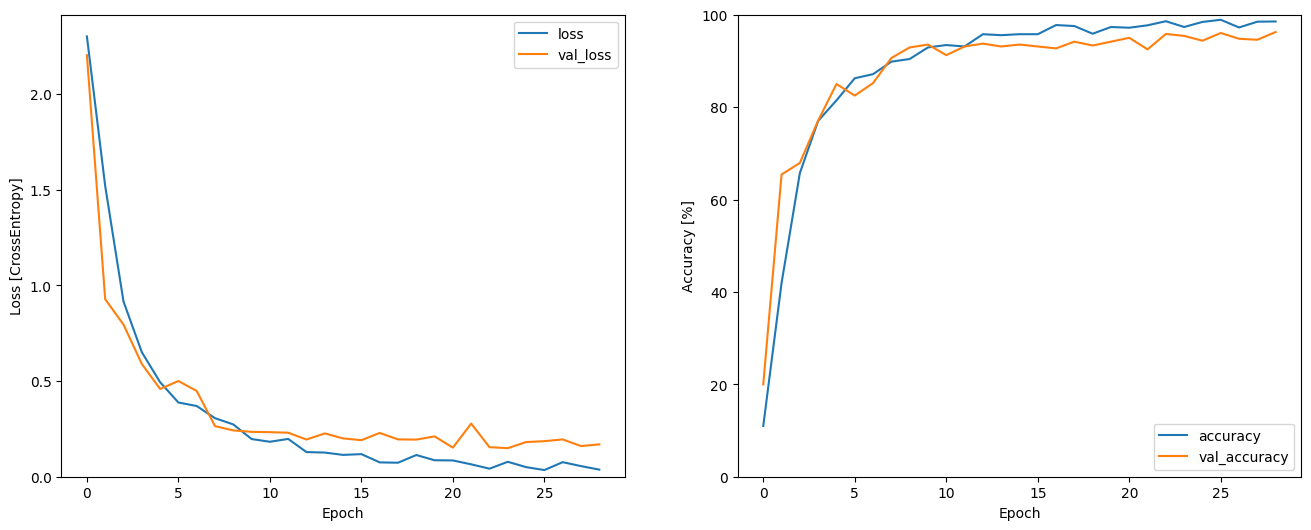

In [48]:
metrics = history_recc.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_recc.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_recc.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [49]:
y_pred = model_recurrent.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)

19/19 [==============================] - 3s 15ms/step


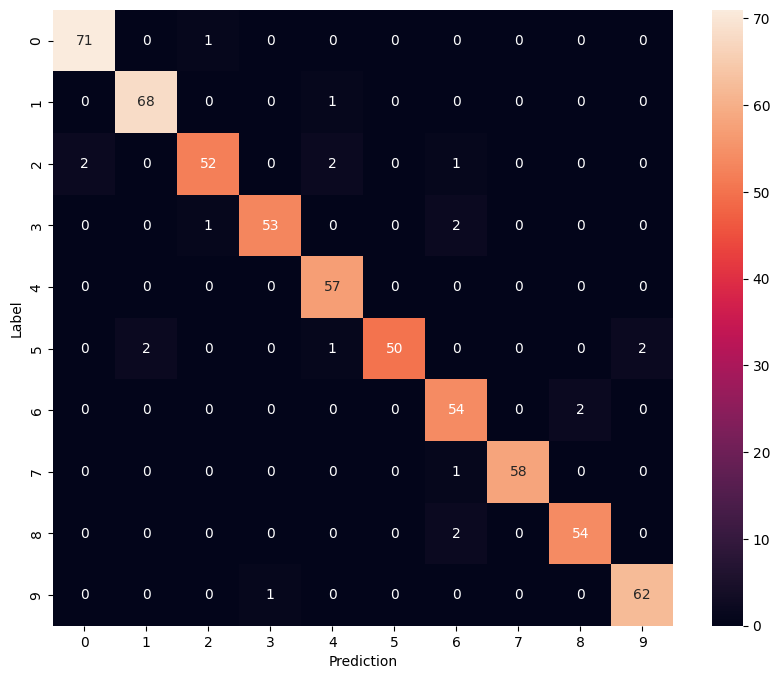

In [50]:
confusion_mtx_rec = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_rec,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [51]:
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.97      0.99      0.98        69
           2       0.96      0.91      0.94        57
           3       0.98      0.95      0.96        56
           4       0.93      1.00      0.97        57
           5       1.00      0.91      0.95        55
           6       0.90      0.96      0.93        56
           7       1.00      0.98      0.99        59
           8       0.96      0.96      0.96        56
           9       0.97      0.98      0.98        63

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600



Prueba de modelos con audios nuestros

In [ ]:
def wav_to_model_input(wav_file_path, target_size=(61, 129)):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.56, 2.56))
    plt.axis('off')
    plt.margins(0, 0)
    plt.imshow(S_db, aspect='auto', cmap=cmap)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.gcf().set_size_inches(spectrogram_dimensions[0] / 100.0, spectrogram_dimensions[1] / 100.0)
    plt.gcf().set_dpi(100)
    plt.savefig(spectrogram_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [ ]:
wav_directory = '/content/Pruebas'


In [ ]:
label_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

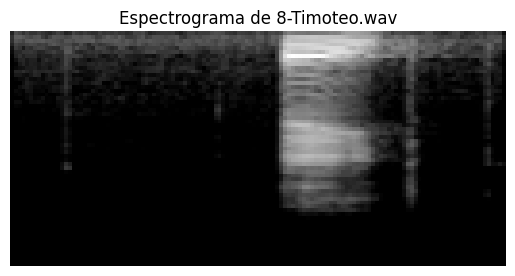

1/1 [==============================] - 0s 94ms/step
Archivo de audio: 8-Timoteo.wav
Predicción del modelo: 8


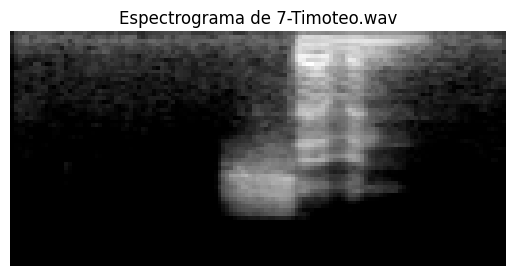

1/1 [==============================] - 0s 105ms/step
Archivo de audio: 7-Timoteo.wav
Predicción del modelo: 8


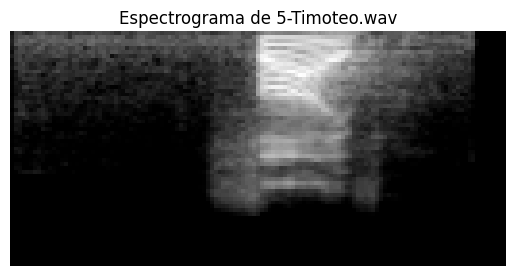

1/1 [==============================] - 0s 104ms/step
Archivo de audio: 5-Timoteo.wav
Predicción del modelo: 8


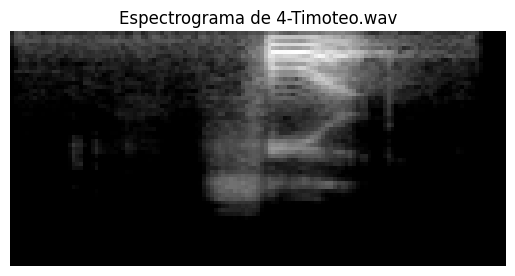

1/1 [==============================] - 0s 257ms/step
Archivo de audio: 4-Timoteo.wav
Predicción del modelo: 8


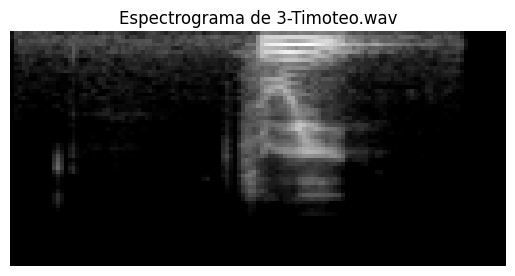

1/1 [==============================] - 0s 162ms/step
Archivo de audio: 3-Timoteo.wav
Predicción del modelo: 8


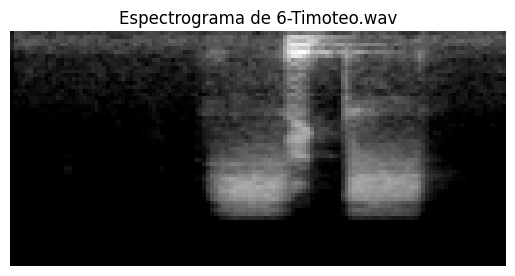

1/1 [==============================] - 0s 41ms/step
Archivo de audio: 6-Timoteo.wav
Predicción del modelo: 6


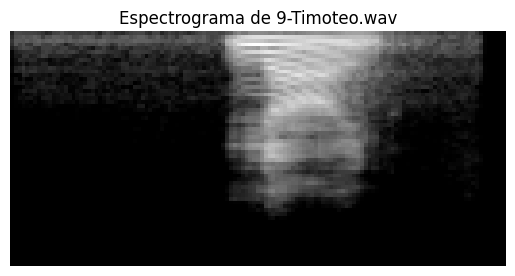

1/1 [==============================] - 0s 85ms/step
Archivo de audio: 9-Timoteo.wav
Predicción del modelo: 8


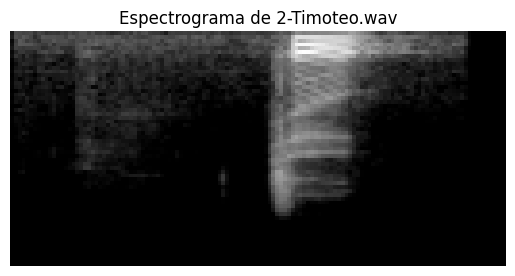

1/1 [==============================] - 0s 48ms/step
Archivo de audio: 2-Timoteo.wav
Predicción del modelo: 8


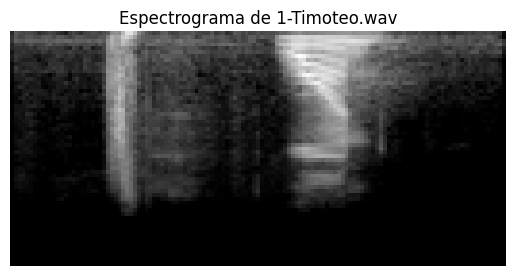

1/1 [==============================] - 0s 52ms/step
Archivo de audio: 1-Timoteo.wav
Predicción del modelo: 8


In [ ]:
for wav_file in os.listdir(wav_directory):
  if wav_file.endswith('.wav'):
    wav_file_path = os.path.join(wav_directory, wav_file)

    # Convertir el archivo .wav a la entrada del modelo
    model_input = wav_to_model_input(wav_file_path)

    # Mostrar el espectrograma
    plt.imshow(model_input.numpy().squeeze(), cmap='gray')
    plt.title(f"Espectrograma de {wav_file}")
    plt.axis('off')
    plt.show()

    # Hacer la predicción
    model_input_expanded = tf.expand_dims(model_input, axis=0)
    prediction = model.predict(model_input_expanded)
    predicted_label = np.argmax(prediction, axis=1)[0]

    print(f'Archivo de audio: {wav_file}')
    print(f'Predicción del modelo: {label_names[predicted_label]}')

    # Reproducir el audio
    y, sr = librosa.load(wav_file_path, sr=None)
    # display(Audio(y, rate=sr))

In [ ]:
def wav_to_spectrogram_recurrent(audio_path, spectrogram_dimensions=(128, 128)):
    # Cargar el archivo de audio
    y, sr = librosa.load(audio_path, sr=None)

    # Generar el espectrograma mel
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Asegurar que el espectrograma tenga las dimensiones correctas
    S_dB_resized = np.zeros(spectrogram_dimensions)
    S_dB_resized[:S_dB.shape[0], :S_dB.shape[1]] = S_dB[:spectrogram_dimensions[0], :spectrogram_dimensions[1]]

    # Normalizar el espectrograma
    S_dB_normalized = (S_dB_resized - np.min(S_dB_resized)) / (np.max(S_dB_resized) - np.min(S_dB_resized))

    return S_dB_normalized

In [ ]:
for wav_file in os.listdir(wav_directory):
    if wav_file.endswith('.wav'):
        wav_file_path = os.path.join(wav_directory, wav_file)

        # Cargar archivo .wav y convertir a secuencia de características
        spectrogram = wav_to_spectrogram_recurrent(wav_file_path)

        model_input = np.expand_dims(spectrogram, axis=0)  # Añadir dimensión de batch si es necesario

        # Realizar la predicción
        prediction = model_recurrent.predict(model_input)

        # Obtener la etiqueta predicha (por ejemplo, el índice de la clase con mayor probabilidad)
        predicted_label = np.argmax(prediction, axis=1)[0]

        print(f'Archivo: {wav_file}, Predicción: {predicted_label}')

1/1 [==============================] - 0s 131ms/step
Archivo: 8-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 175ms/step
Archivo: 7-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 271ms/step
Archivo: 5-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 421ms/step
Archivo: 4-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 341ms/step
Archivo: 3-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 389ms/step
Archivo: 6-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 212ms/step
Archivo: 9-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 218ms/step
Archivo: 2-Timoteo.wav, Predicción: 2
1/1 [==============================] - 0s 136ms/step
Archivo: 1-Timoteo.wav, Predicción: 2
